In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import numpy as np
import struct
import sys
from array import array
import itertools
import os
#from scipy import signal
#from scipy.optimize import curve_fit
#from scipy.signal import find_peaks
import subprocess
import shutil
import pandas as pd
#from PIL import Image, ImageDraw
from matplotlib.animation import FuncAnimation, PillowWriter  

import utl
import fit_omega

pi = np.pi
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
clight = 299792458

In [69]:
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c

In [70]:
def get_folders(folders,cwd):
    new_folders = []
    for folder in folders:
        if os.path.isdir(os.path.join(cwd,folder)):
            new_folders.append(folder)
    return new_folders

In [71]:
os.getcwd()

'/home/txin/Dropbox/My PC (DESKTOP-MIKK45R)/Documents/Work/Code/APES/APES_CBI/view'

In [72]:
working_folder = '/media/tianmu/data/Data_for_Projects/CEPC/Sims/Higgs_on_Axis/SR/Higgs_Transient/8TrainsX2/'
working_folder = '/home/txin/Documents/Work_Folder/Code/APES/unit_Test/CEPC/Unit_Test/'

result_idx = 0
home0 = os.getcwd()
home1 = os.path.join(home0,working_folder)
cwd = working_folder#os.path.join(home0,working_folder)

In [73]:
folders = os.listdir(cwd);
new_folders = get_folders(folders,cwd);
new_folders = np.sort(new_folders);
print(new_folders)

['0']


In [74]:
inputfile = 'input.txt'
temppath = os.path.join(cwd,new_folders[result_idx])
inputfile = os.path.join(temppath,inputfile)
tempinput = {}
tempinput = utl.get_input_para(inputfile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nDynamic = int(tempinput['n_dynamicOn'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nGap = h[0]/fill_step-nBunch
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
frf = f0*np.array(h)
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
t_rad_long = tempinput['t_rad_long'][0]
nTrain = int(tempinput['nTrain'][0])
Pattern = np.array(tempinput['Pattern']).astype(int)

if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF == 2 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))
    
elif nRF == 3 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1]+V0[2]*h[2]/h[0])*eta/(2*np.pi*Ek))
omega0 = f0*2*pi
omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf

RoQ0 = [i for i in tempinput['RoQ']]

RoQ = np.array(RoQ0)/1
QL0 = [i for i in tempinput['QL']]
QL = np.array(QL0)*1
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)


print(Qs)
print(bucket_height)

0.04807471904742432
0.06262582762773311


In [75]:
thetaL1 = 0
IbDC = nBunch*f0*1.6e-19*NperBunch
f = f0*np.array(h)
Vbr = IbDC*2*np.array(RoQ)*np.array(QL)
Vc = np.sqrt(np.array(V0)**2+np.array(V0Q)**2)
Phis = np.arctan(np.array(V0)/np.abs(np.array(V0Q)))
tanpsi = -(Vbr/Vc*np.sin(Phis)+np.tan(np.array(thetaL1)/180*pi)*(1+Vbr/Vc*np.cos(Phis)))
#tanpsi = -(Vbr/Vc*np.sin(Phis)+np.tan(np.array(thetaL)/180*pi)*(1+Vbr/Vc*np.cos(Phis)))
df = tanpsi/2/QL*f
df_opt = -(Vbr/Vc*np.sin(Phis))/2/QL*f
ddf = df-df_opt

In [76]:
# Read the M1
M1_all,M1_1,M1_2 = utl.read_M1(temppath,nTurns,nBeam,nBunch,Gamma0)

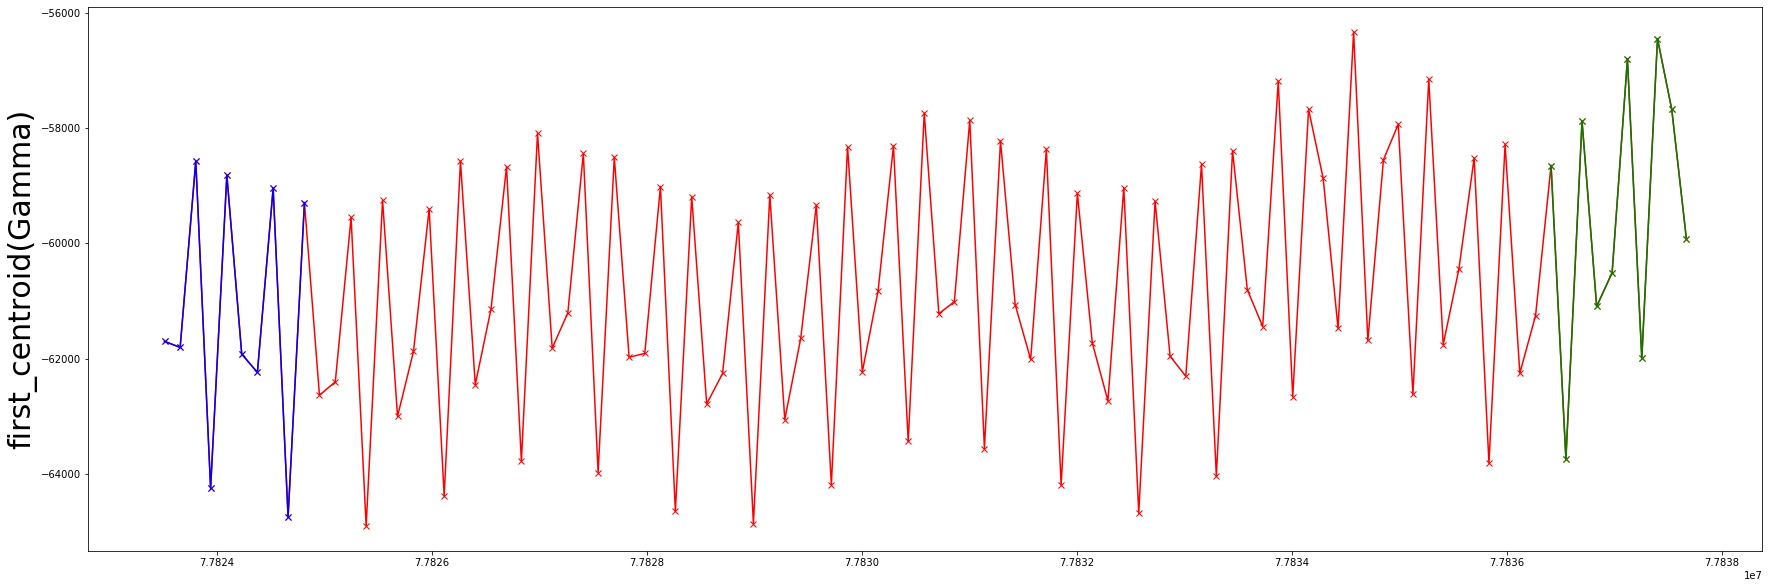

In [77]:
# Plot the first bunch centroid
M1_1_0,M1_2_0 = utl.get_first_bunch_M1(nTurns,nBunch,Gamma0,M1_all)
turn = int(300)
n_turn_disp = int(100)

utl.plot_firt_bunch_centroids(M1_1_0,M1_2_0,T0,h,temppath,nTurns,turn,n_turn_disp)

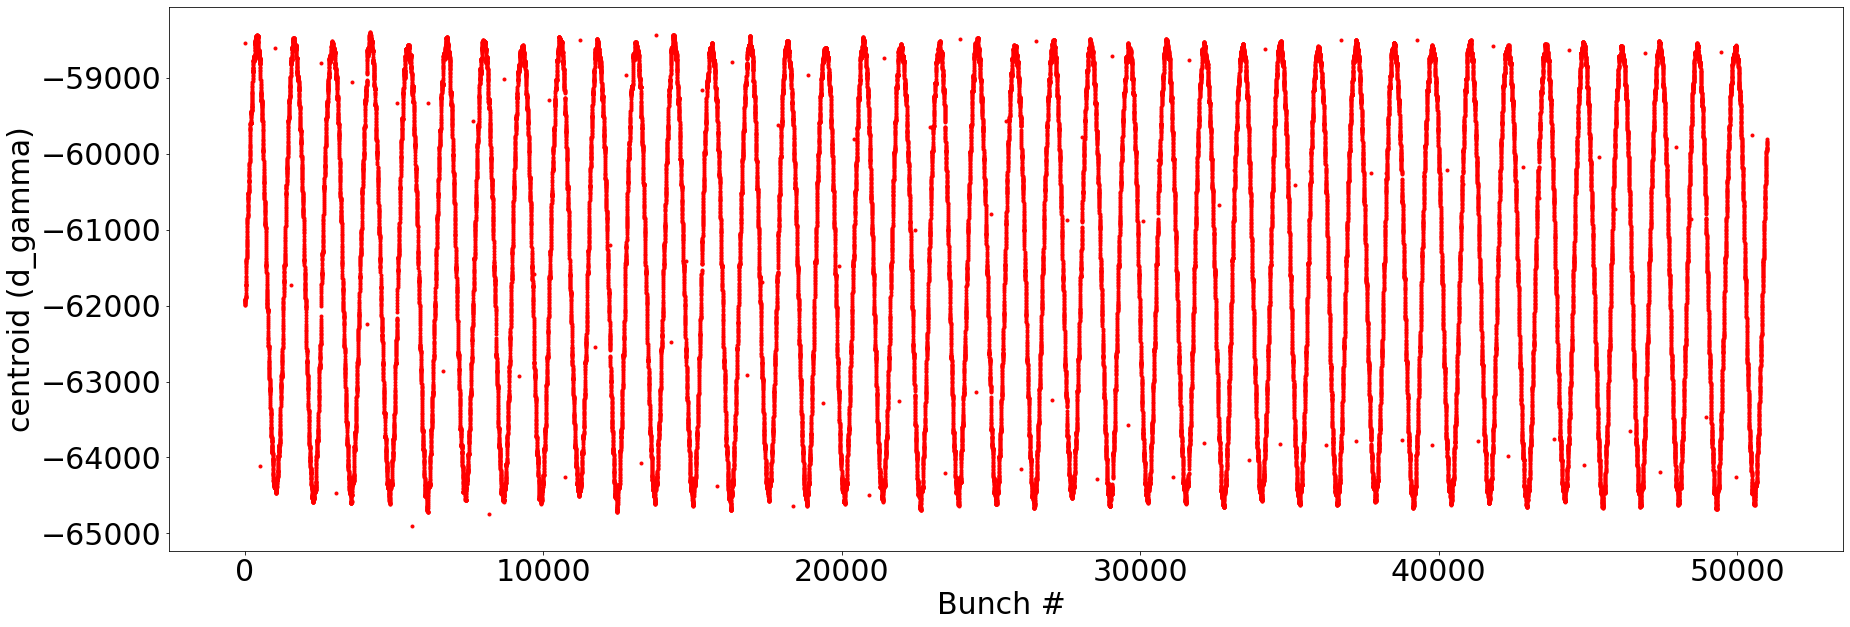

In [78]:
# Plot Centroids d_gamma along the train. 
turn = int(400)
n_turn_disp = int(100)

utl.plot_centroids_gamma(M1_1,M1_2,T0,h,temppath,nTurns,turn,n_turn_disp,nBunch)

nTrain:  1


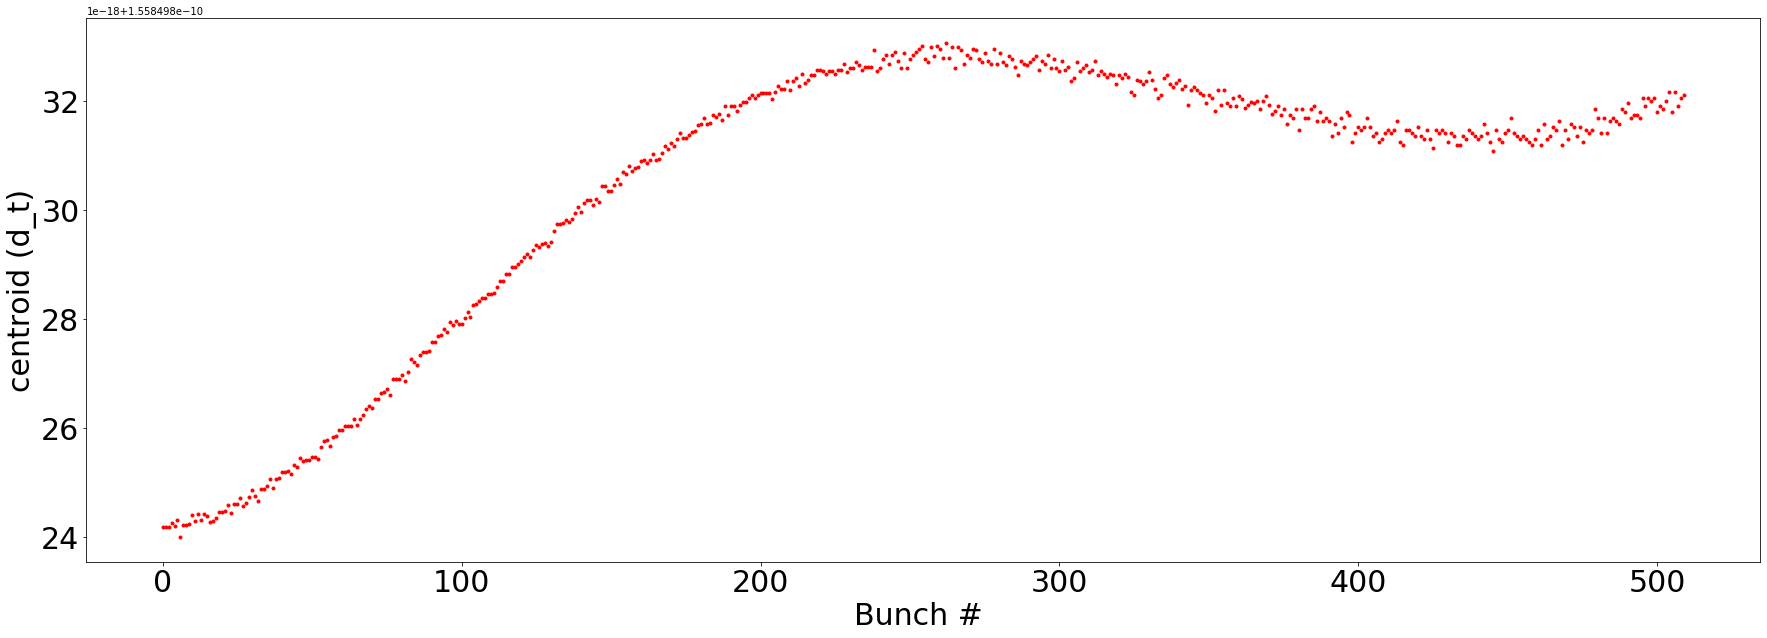

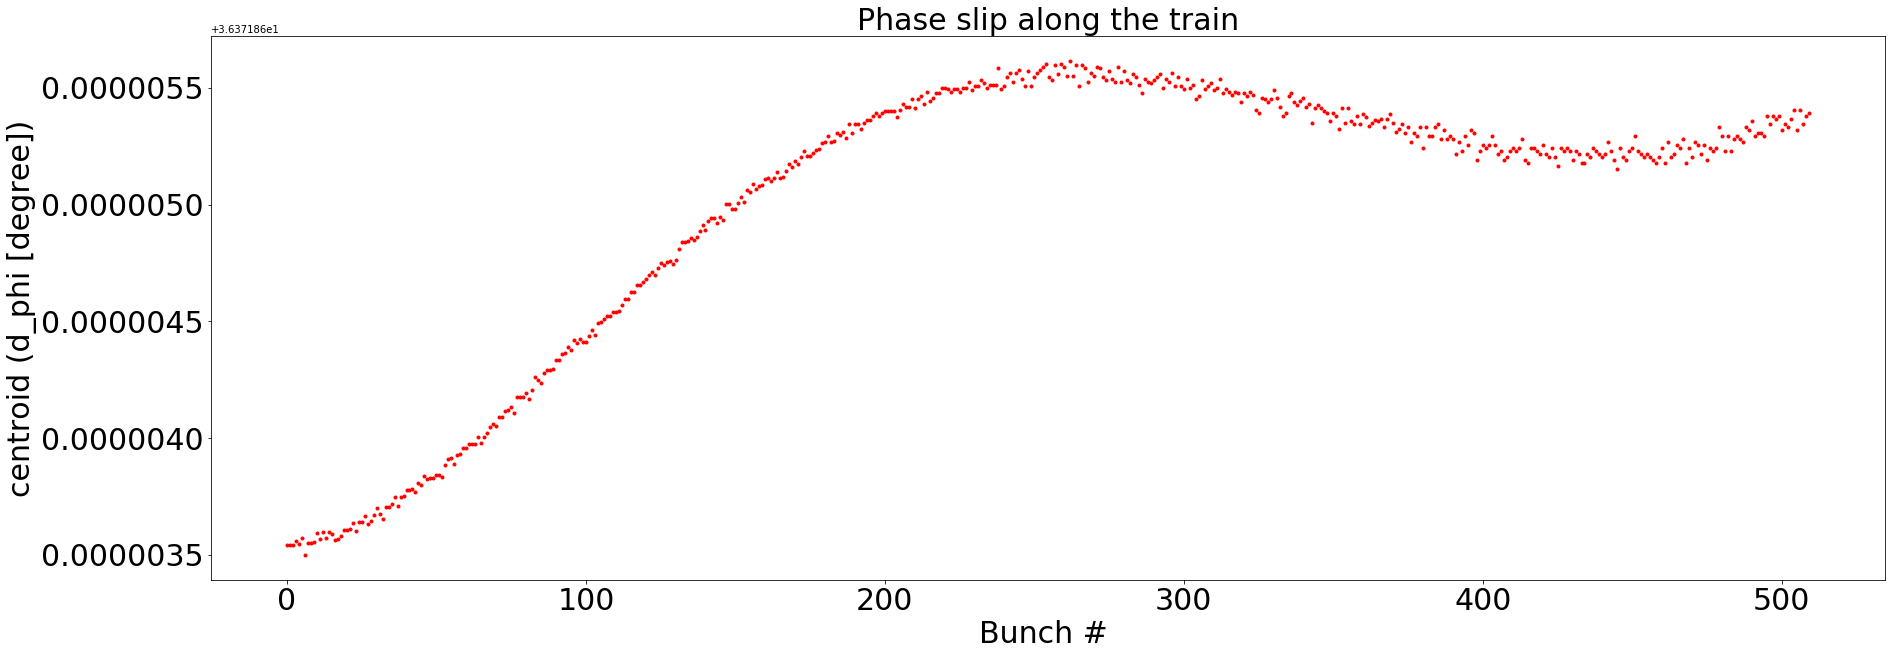

In [58]:
centroids = utl.get_centroids(Pattern,Trf[mainRF],nBunch,Trf[mainRF]/2,fill_step)#[(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
turn_start = 999
turn_end = 999
train_start = 0
train_end = 0
bunch_start = 0
bunch_end = nBunch

utl.plot_centroids_t(M1_1,centroids,T0,h,temppath,nTurns,nTrain, turn_start,turn_end,train_start,train_end,bunch_start,bunch_end,Pattern, nBunch)
utl.plot_centroids_phi(M1_1,centroids,T0,h,f,temppath,nTurns,nTrain, turn_start,turn_end,train_start,train_end,bunch_start,bunch_end,Pattern, nBunch)

In [59]:
k = RoQ/2*omegarf
I0=np.sum([Pattern[i*3] for i in range(int(len(Pattern)/3))])*1.6e-19*NperBunch/T0
Tg=Pattern[2]/(omegarf/2/pi)
Vc=Vc
phi0 = Phis[0]
dtheta = 2*k*I0*Tg/(Vc*np.sin(phi0))*180/pi
print(dtheta)

[0.]


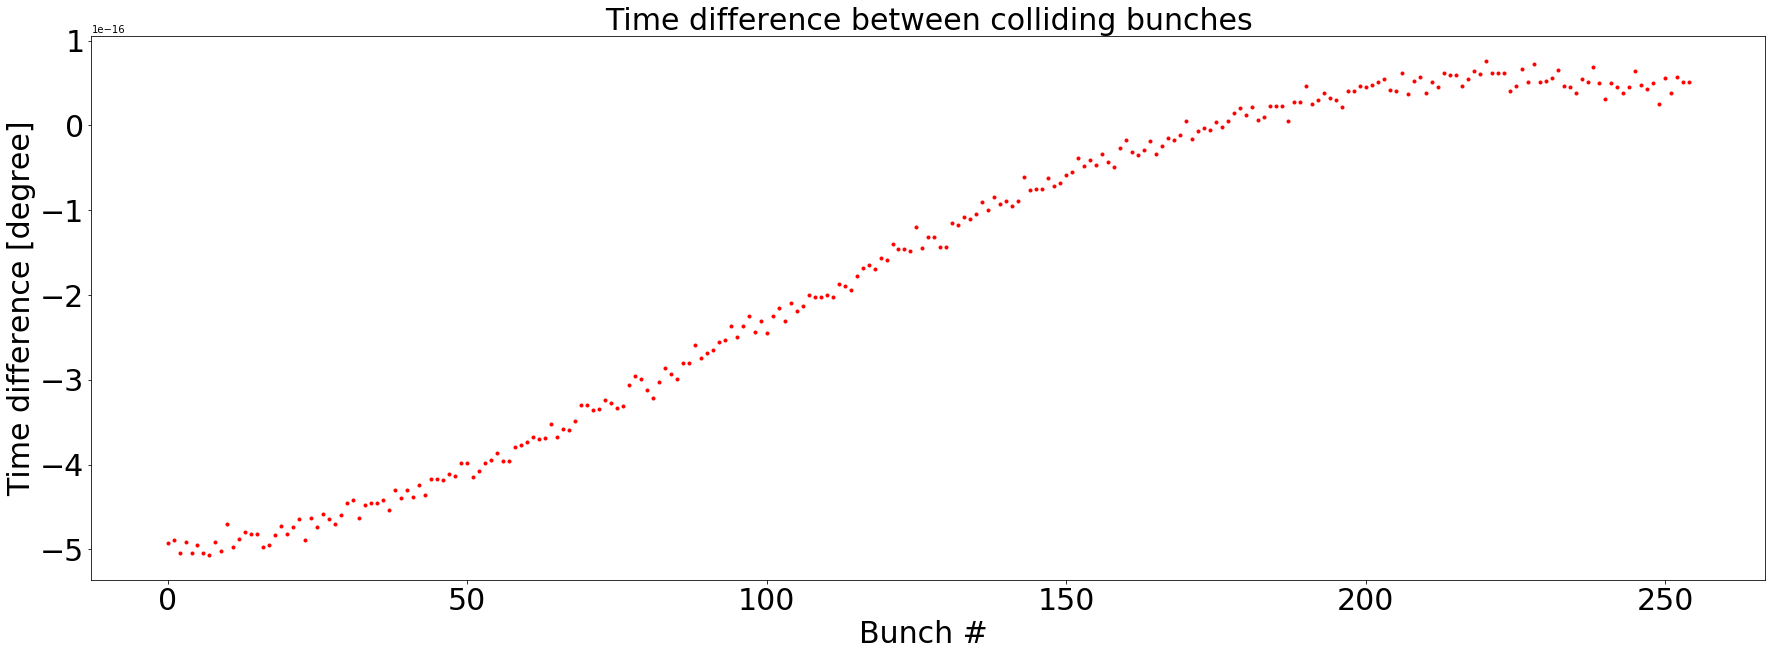

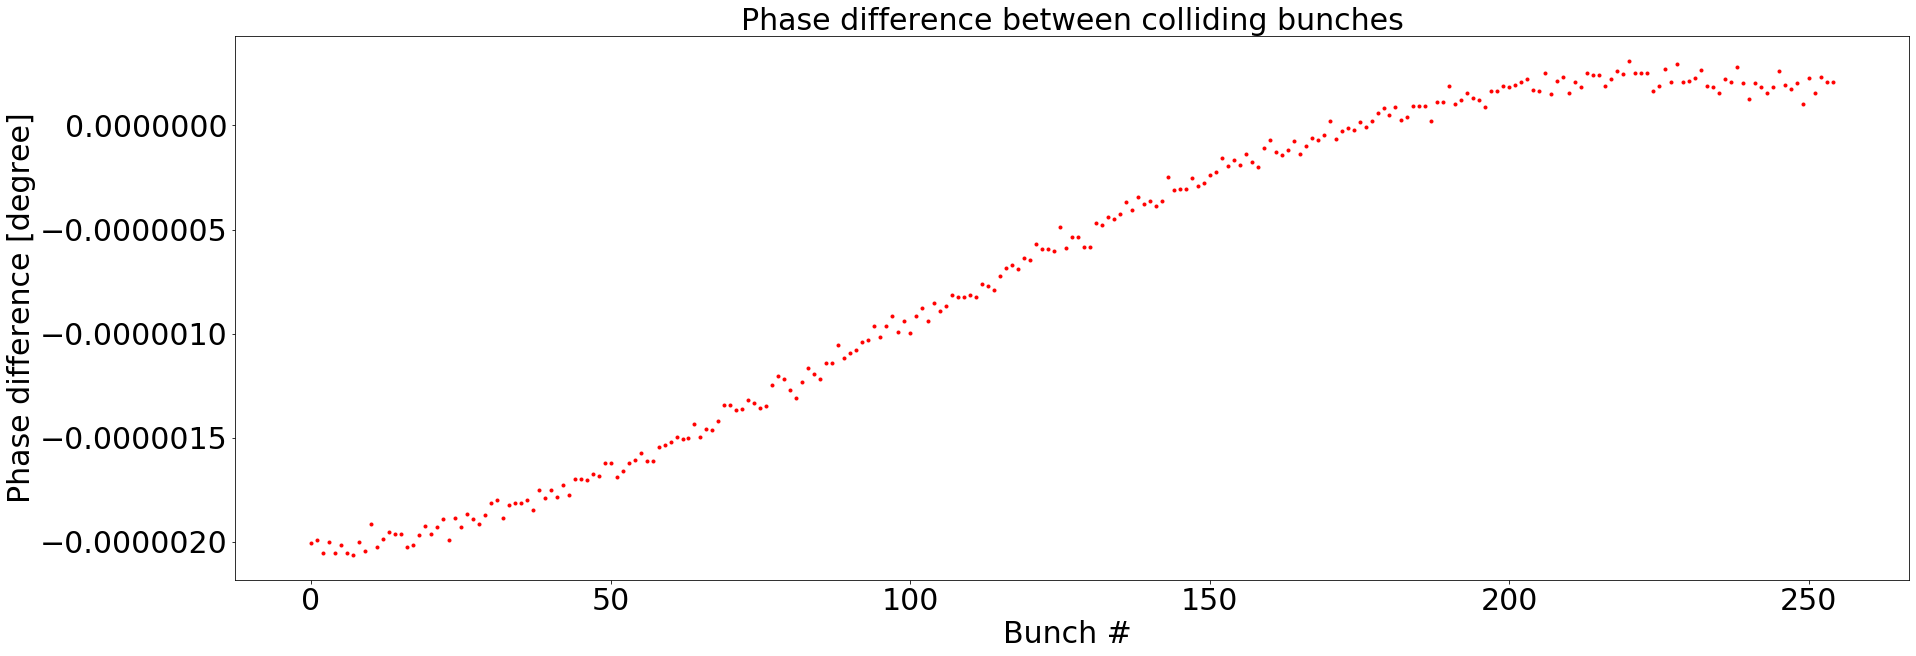

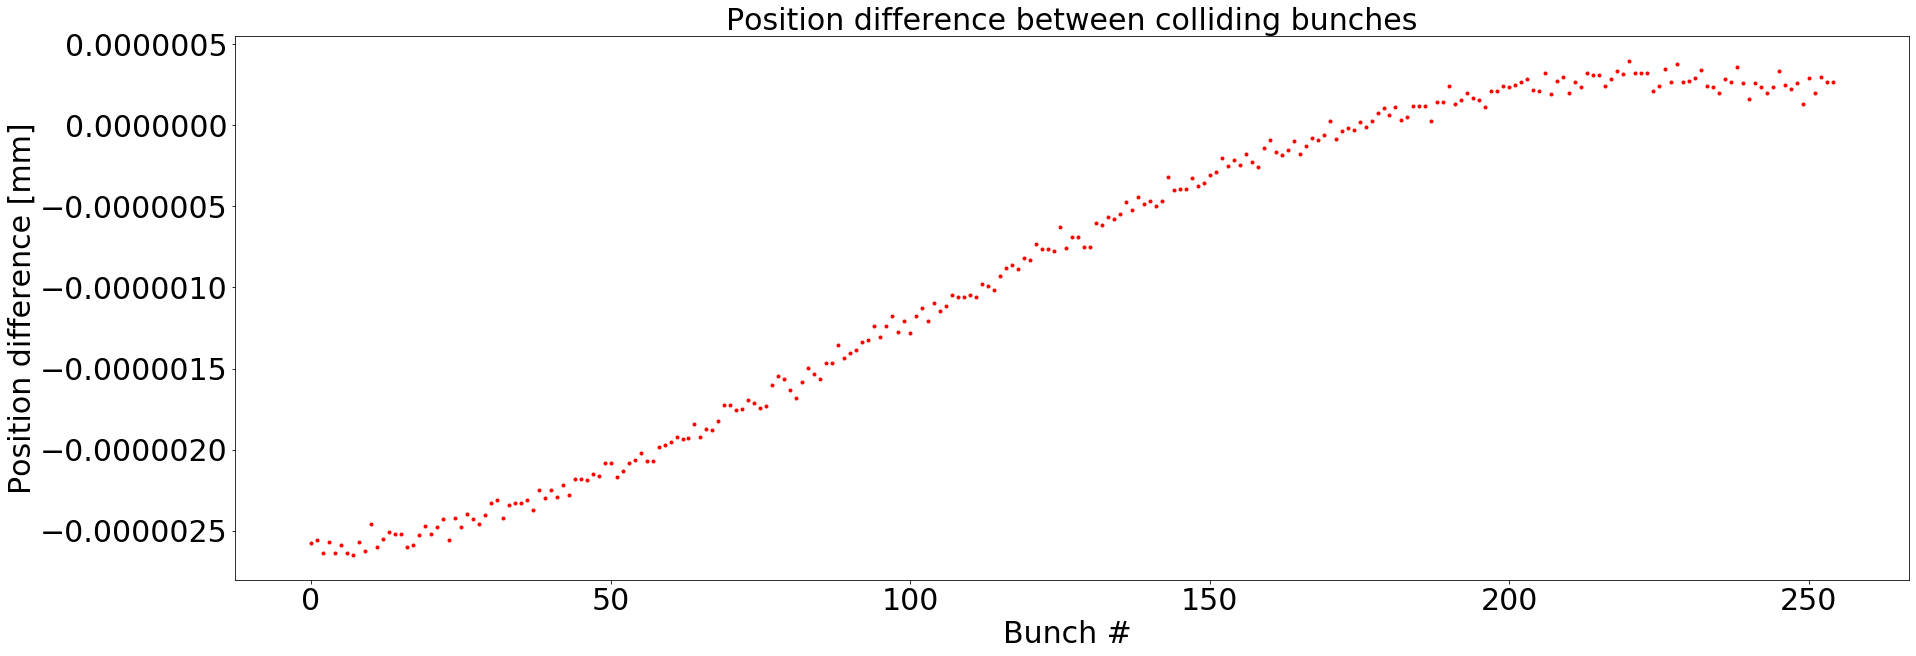

In [60]:
turn_start = 999
turn_end = 999
train_start = 0
train_end = 0
bunch_start = 0
bunch_end = nBunch

utl.plot_dPhi(M1_1,centroids,T0,h,f,Trf, temppath,nTurns,nTrain, turn_start,turn_end,train_start,train_end,bunch_start,bunch_end,Pattern, nBunch)

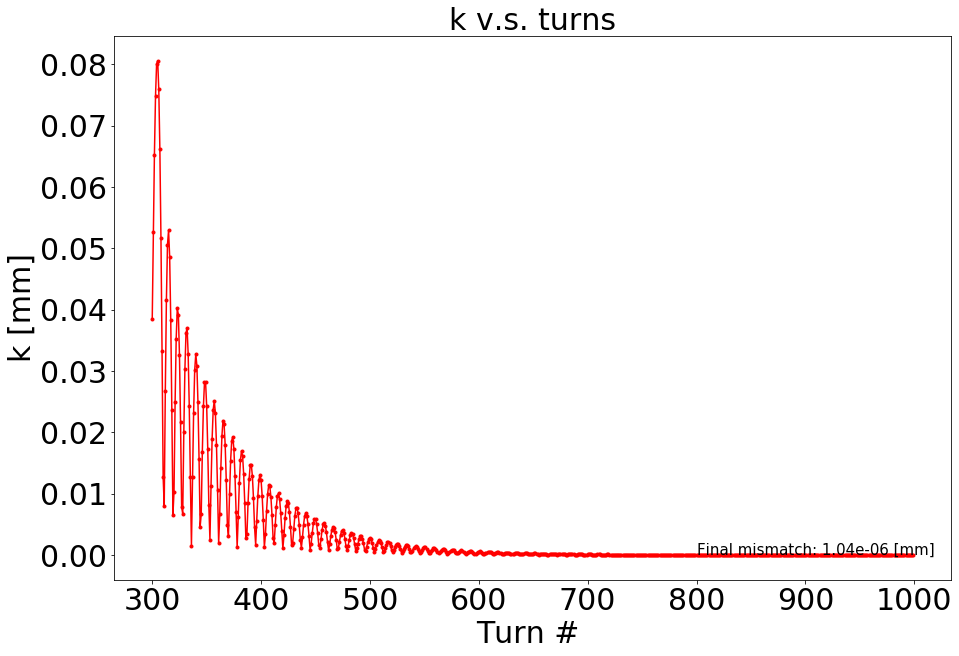

In [61]:
n_start = 300
n_end = 1000
n_step = 1
for_gif1 = False
for_gif2 = False
cal_dphase = True
utl.plot_anim(n_start,n_end,n_step,omegarf,for_gif1,for_gif2,cal_dphase,nBunch,nTrain,Pattern,M1_1,centroids,f,temppath)

In [62]:
# Plot lengthes, delta_gamma and emittance
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

for folder in new_folders[6:7]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M2_all = array('d')
    M2_fn = 'M2_all.bin'
    datafile = os.path.join(cwd,M2_fn)    
    print("Tot data ",3*nTurns*nBeam*nBunch)
    with open(datafile, mode='rb') as file: # b is important -> binary
        M2_all.fromfile(file,3*nTurns*nBeam*nBunch)
    M2_1 = []
    M2_2 = []
    M2_3 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M2_1.append(M2_all[i*nBunch*3+j])
            M2_2.append(M2_all[i*nBunch*3+nBunch+j])
            M2_3.append(M2_all[i*nBunch*3+nBunch*2+j])
    Emittance = np.sqrt(np.array(M2_1)*np.array(M2_2)-np.array(M2_3)**2)/Gamma0*Ek
    M2_1 = np.sqrt(np.array(M2_1))
    M2_2 = np.sqrt(np.array(M2_2))
    M2_3 = np.array(M2_3)
    
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    
    fig1,axes1 = plt.subplots(3,1)
    fig1.set_figheight(10*3)
    fig1.set_figwidth(30)
    
    turns = 999
    rng1 = turns*nBunch
    rng2 = rng1+nBunch*1
    
    idx_stop = np.where(np.array(M2_1[:])*clight*1000>100)
    #print("first bad idx : ",idx_stop)
    if len(idx_stop[0])>0:
        rng2 = nBunch*int(idx_stop[0][0]/nBunch)
        print("rng2: ",rng2)
    else:
        print("2")
        #rng2 = rng1+nBunch*2000
        rng2 = rng1+nBunch*1
    rng2 = rng1+int(nBunch*1/2)
    rng3 = rng2+int(nBunch*1/2)
    axes1[0].plot(np.array([i for i in range(rng2-rng1)]),np.array(M2_1[rng1:rng2])*clight*1000,'r.')
    axes1[0].plot(np.array([i+rng2-rng1 for i in range(rng2-rng1)]),np.array(M2_1[rng2:rng3])*clight*1000,'b.')
    #axes1[0].set_title("Plot at turn # "+str(turns),fontsize=30)
    axes1[0].set_ylabel('sig_length [mm]',fontsize=30)
    #axes1[0].set_xlabel('Bunch # x Turn #',fontsize=30)
    axes1[0].set_xlabel('Bunch # ',fontsize=30)
    axes1[0].tick_params(labelsize=30)
    
    axes1[1].plot(np.array(M2_2[rng1:rng2])/Gamma0,'r.')
    axes1[1].set_ylabel('sig_dGamma/Gamma0',fontsize=30)
    axes1[1].set_xlabel('Bunch # x Turn #',fontsize=30)
    axes1[1].set_xlabel('Bunch # ',fontsize=30)
    axes1[1].tick_params(labelsize=30)
    
    axes1[2].plot(Emittance[rng1:rng2],'r.')
    axes1[2].set_ylabel('Emittance [eV.sec]',fontsize=30)
    axes1[2].set_xlabel('Bunch # x Turn #',fontsize=30)
    axes1[2].set_xlabel('Bunch # ',fontsize=30)
    axes1[2].tick_params(labelsize=30)
    
    fn_after = os.path.join(cwd,'Logitudinal_'+str(turns)+'_'+str((rng2-rng1)/nBunch)+'.png')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
    temp_sigz = np.array(M2_1[rng1:rng2])*clight*1000
    mean_sigz = np.mean(temp_sigz)
    std_sigz = np.std(temp_sigz)
    print(mean_sigz)
    print(std_sigz)
os.chdir(home0)

In [63]:
def get_the_turn_number(c,value):
    print(len(c))
    for i in range(len(c)):
        if c[i]>=value:
            print(i,",",c[i])
            return i
    return i

inputfn = 'input.txt'
N_mode = 10 # number of mode to look
mu_danger = 0 # the mode we think is the most dangers
mus = np.array([i for i in range(N_mode)])

1000
101 , 533.7090618653172
The turn number when amplitude reach  80 : 101.0
[0. 0. 0.]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
1000
The turn number when amplitude reach  80 : 999.0


/home/txin/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/txin/Dropbox/My PC (DESKTOP-MIKK45R)/Documents/Work/Code/APES/APES_CBI/view/fit_omega.py:20: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x)+c


[ 0.99937222 -0.00314636  0.97427953]
[[ 1.29554452e-01  2.95585294e-04 -6.88362134e-02]
 [ 2.95585294e-04  1.27879703e-05 -1.20918393e-03]
 [-6.88362134e-02 -1.20918393e-03  1.36021600e-01]]
1000
The turn number when amplitude reach  80 : 999.0
[ 0.99891179 -0.00358703  0.42308192]
[[ 2.66555441e-02  4.24329918e-06 -8.25628008e-03]
 [ 4.24329918e-06  3.03226122e-06 -2.19069084e-04]
 [-8.25628008e-03 -2.19069084e-04  1.99672258e-02]]
1000
The turn number when amplitude reach  80 : 999.0
[ 0.99981735 -0.00359127  0.1823342 ]
[[ 1.05524073e-02  1.47783306e-06 -3.25068599e-03]
 [ 1.47783306e-06  1.19933432e-06 -8.65122558e-05]
 [-3.25068599e-03 -8.65122558e-05  7.87769046e-03]]
1000
The turn number when amplitude reach  80 : 999.0
[ 0.99999962 -0.00358384  0.06106145]
[[ 5.35354057e-03  9.27920769e-07 -1.66502967e-03]
 [ 9.27920769e-07  6.07259975e-07 -4.40015138e-05]
 [-1.66502967e-03 -4.40015138e-05  4.02055572e-03]]
1000
The turn number when amplitude reach  80 : 999.0
[-0.25925222 -2.

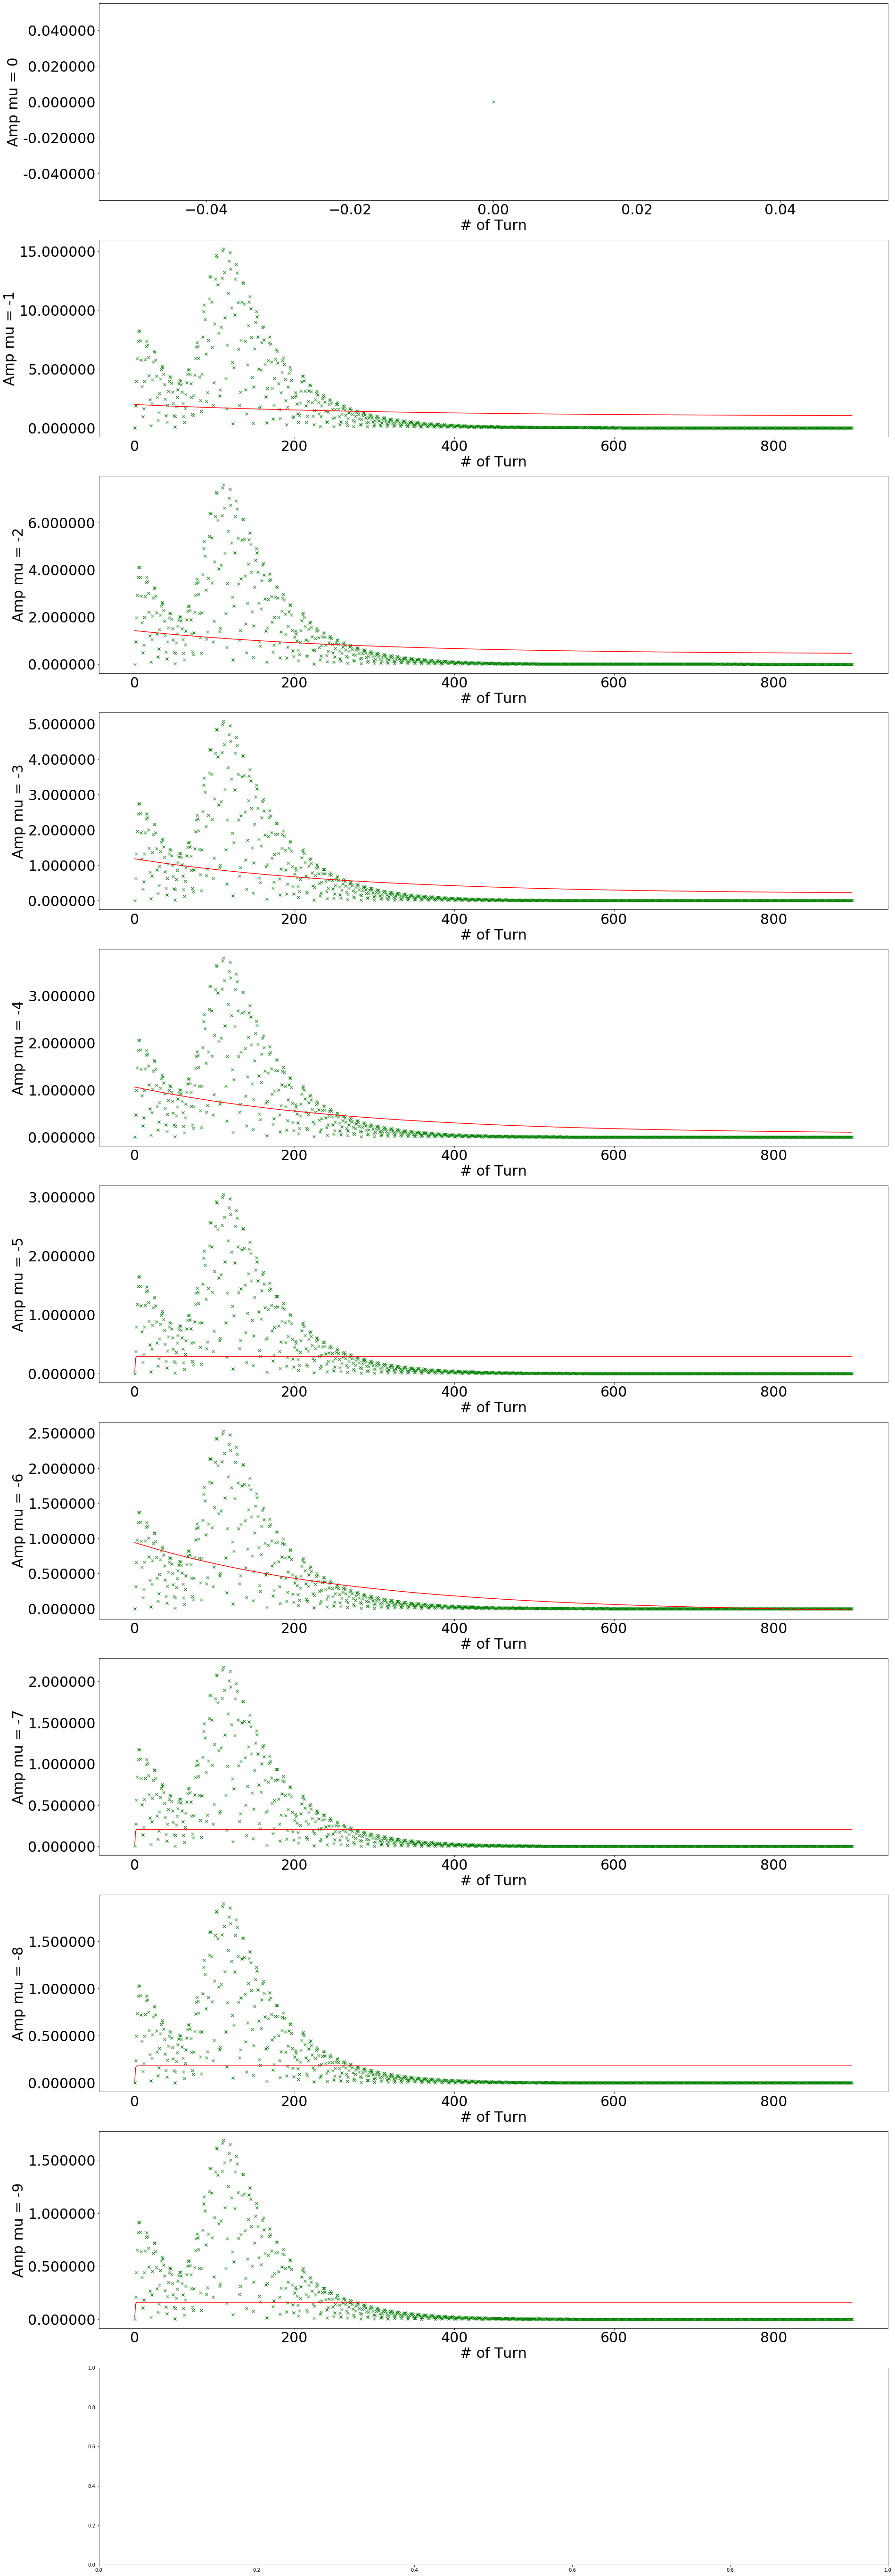

In [64]:
thresh = 80
qs = fit_omega.fit_growth(N_mode,nTurns,thresh,nBunch,Gamma0,eta,Qs,T0,nDynamic,M1_1,M1_2,temppath)

0
1000
101 , 217.50058897791519
The turn number when amplitude reach  80 : 101.0


TypeError: object of type 'int' has no len()

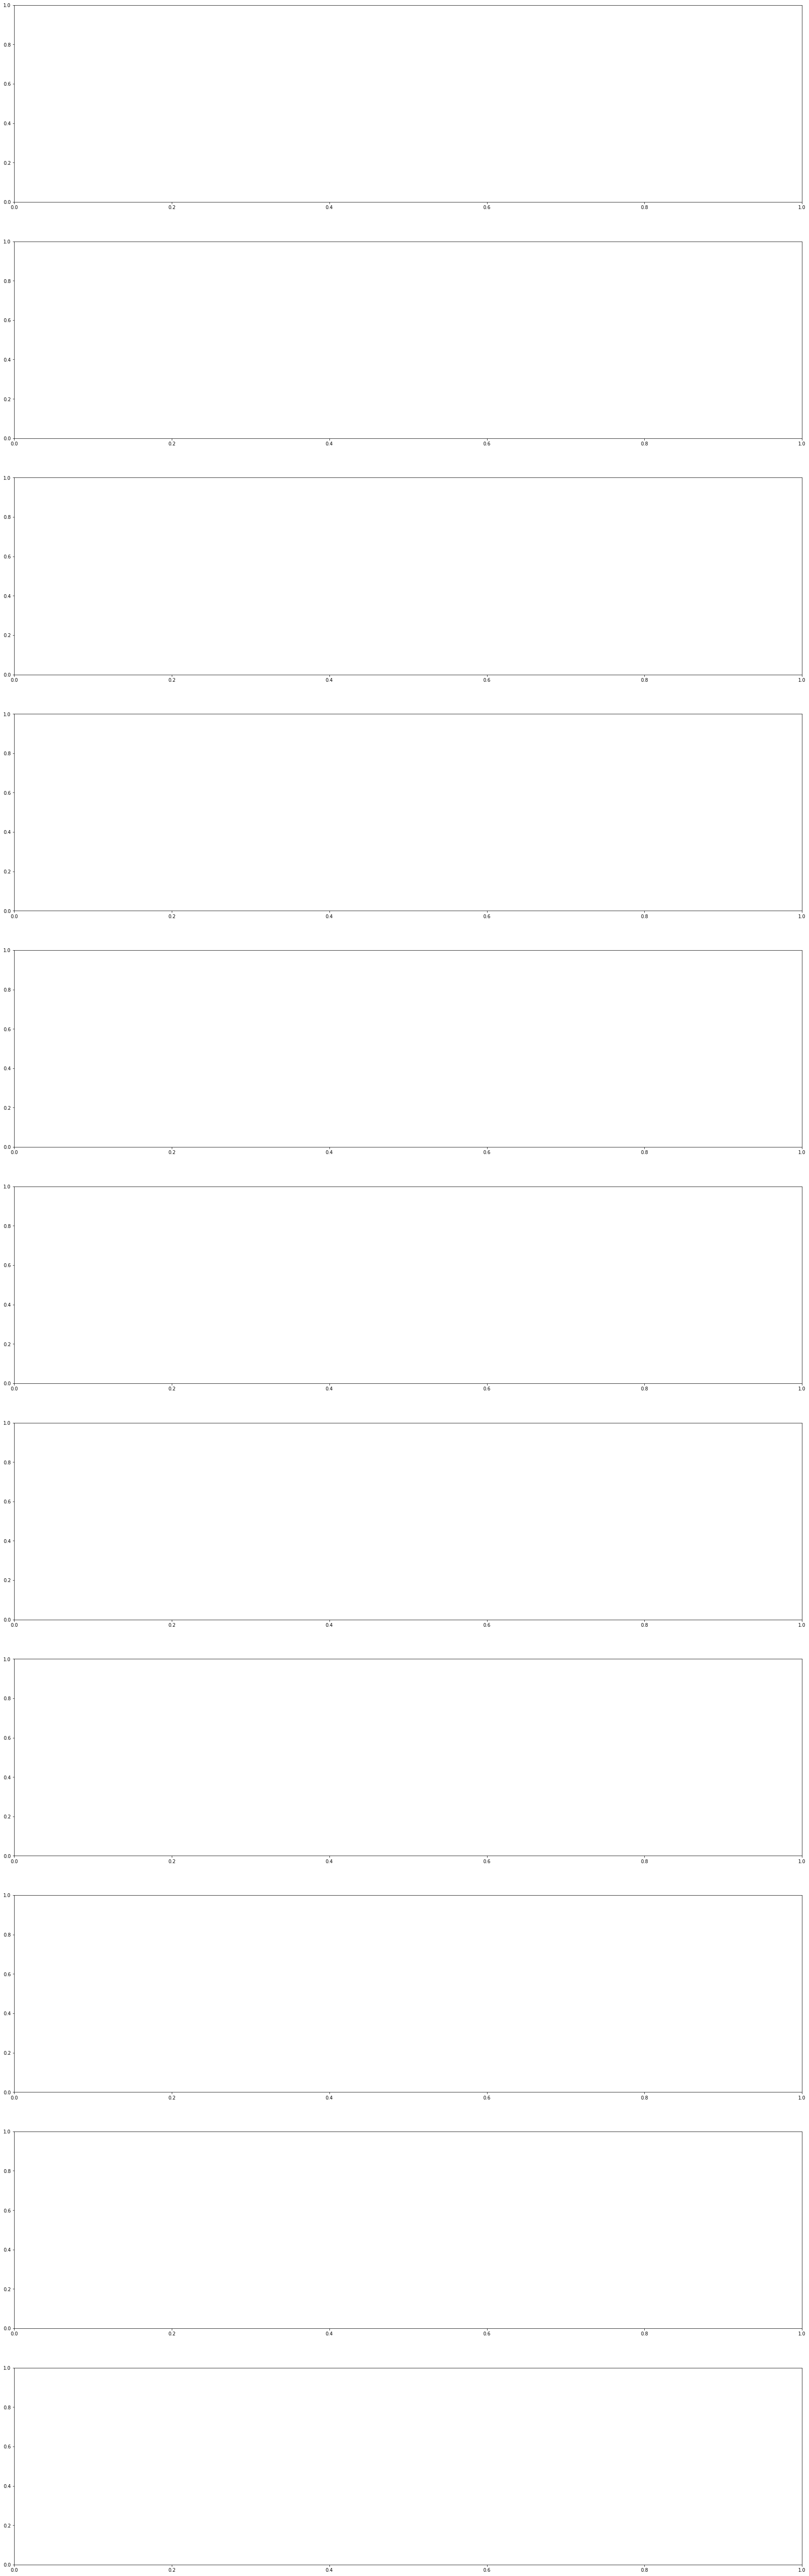

In [18]:
# get the fitted growth rate
# first, find the turn number where the mu=1 mode amplitude exceed certain value

centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
qs = np.ndarray([N_mode,len(new_folders)])
taus = np.ndarray([N_mode,len(new_folders)])
centroids = np.array([(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)])
ids = np.array([i for i in range(nBunch)])

q_guess = 0.01
qidx = 0
N_samp_disp = 50
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    if nRF ==1:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
    elif nRF == 2 or nRF == 3:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    for turn in range(nTurns):
        M1_1[turn*nBunch:(turn+1)*nBunch] = np.array(M1_1[turn*nBunch:(turn+1)*nBunch]-centroids)
# calculate the components
    sincomp = []
    coscomp = []
    a1 = np.ndarray([N_mode,nTurns])
    b1 = np.ndarray([N_mode,nTurns])
    a2 = np.ndarray([N_mode,nTurns])
    b2 = np.ndarray([N_mode,nTurns])
    
    c = np.ndarray([N_mode,nTurns])
    d = np.ndarray([N_mode,nTurns])
    e = np.ndarray([N_mode,nTurns])
    
    value = 80 # the value where we stop the plotting
    
    idx = np.zeros(N_mode)
    
    fig1,axes1 = plt.subplots(N_mode+1,1)
    fig1.set_figheight(10*(N_mode))
    fig1.set_figwidth(30)
    
    for mu in range(N_mode):
        #sincomp.append(np.sin((nBunch-mu)*2*pi*f0*np.array(centroids)))
        #coscomp.append(np.cos((nBunch-mu)*2*pi*f0*np.array(centroids)))
        sincomp.append(np.sin((nBunch+mu)*2*pi/nBunch*ids))
        coscomp.append(np.cos((nBunch+mu)*2*pi/nBunch*ids))
        for i in range(nTurns):
            a1[mu][i] = np.sum(sincomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(sincomp[mu])*2
            b1[mu][i] = np.sum(coscomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(coscomp[mu])*2
            a2[mu][i] = np.sum(sincomp[mu]*M1_1[i*nBunch:(i+1)*nBunch])/len(sincomp[mu])*2
            b2[mu][i] = np.sum(coscomp[mu]*M1_1[i*nBunch:(i+1)*nBunch])/len(coscomp[mu])*2
        c[mu] = np.sqrt(np.array(a1[mu])**2+np.array(b1[mu])**2) #gamma
        d[mu] = np.sqrt(np.array(a2[mu])**2+np.array(b2[mu])**2)*Gamma0/eta*Qs*2*pi/T0 #time
        e[mu] = np.sqrt(c[mu]**2+d[mu]**2)
        
        idx[mu] = get_the_turn_number(c[mu],value)
        print("The turn number when amplitude reach ",value,":",idx[mu])
        
        # fit the growth rate
        rng1 = nDynamic
        rng2 = int(idx[mu])
        if rng1>rng2:
            rng1 = 0
        if c[mu][rng2]<c[mu][0]:
            rng2 = nTurns
        #rng2 = rng1+7000
        cNew = c[mu][rng1:rng2]
        turn_temp = range(rng2-rng1)
        # the guessed value of growth rate
        if qidx<=len(thetaL1)/2:
            q_guess = 1.8
        else:
            q_guess = 0.6
        popt, pcov = curve_fit(func_exp_fit, turn_temp, \
                               cNew,bounds=([-cNew[0]*20,-q_guess,-cNew[0]*0.5], [cNew[0]*20, q_guess, cNew[0]*0.5]),\
                               maxfev=200000000)
        print(popt)
        print(pcov)
        qs[mu][qidx] = popt[1]
        c_fit =  popt[0]*np.exp(popt[1]*turn_temp)+popt[2]
        axes1[mu].plot(c[mu][rng1:rng2],'gx')
        axes1[mu].plot(c_fit,'r-')
        axes1[mu].tick_params(labelsize=50)

        axes1[mu].set_xlabel('# of Turn',fontsize=30)
        axes1[mu].set_ylabel('Amp mu = '+str(-mu),fontsize=30)

        axes1[mu].tick_params(labelsize=30)
        y_labels = axes1[mu].get_yticks()
        axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))
    qidx+=1 # for each parameter sample point
    fn_after = os.path.join(cwd,'CB_Modes.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(20)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,qs[mu],'rx-')
plt.show()
os.chdir(home0)

In [ ]:
# Omega_Im = qs/T0 vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL[rng1:rng2],qs[mu][rng1:rng2]/T0,'r.', ms=30)
    axes1[mu].axhline(y=0)
    axes1[mu].set_ylabel('Im(OMEGA)',fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# Omega_Im = qs/T0 vs current
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,qs[mu]/T0,'rx-')
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].set_ylabel('Im(OMEGA)',fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# Omega_Im = qs/T0 vs gain
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(gain,qs[mu]/T0,'rx-')
    axes1[mu].set_xlabel('gain',fontsize=30)
    axes1[mu].set_ylabel('Im(OMEGA)',fontsize=30)
    axes1[mu].legend(["Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_gain.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# get analitical number from simple formula (Chao's book)
def Zparallel(Rsh, QL, omega0, omega,gain):
    return Rsh/(1+gain)*omega/(omega+1j*QL/(1+gain)*(omega0-omega**2/omega0)) # using the convention from A. Chao's book
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)
sigz =  2.5e-3#clight/(f0*h[0])/NpRF # rms bunch length
sigt = sigz/clight #33e-12
sigPhi = 2*pi*f0*sigt

#pmax = 1*64 # number of samples in frequency domain
pmax = int(5*np.sqrt(2)/sigt/nBunch/omega0)
omegas = Qs*f0*2*pi
delta_omega_Re = np.zeros(len(new_folders))
delta_omega_Im = np.zeros(len(new_folders))

delta_omega_Re = np.ndarray([N_mode,len(new_folders)])
delta_omega_Im = np.ndarray([N_mode,len(new_folders)])
ps = np.array([float(i) for i in range(-pmax,pmax+1)])

p_M_omega0 = ps*nBunch*2*np.pi*f0
print("fs = ",omegas/2/pi)
omegas = Qs*2*pi*f0
for mu in mus:
    print("mu = ",mu)
    qidx=0
    for folder in new_folders[:]:
        #print(folder)
        os.chdir(os.path.join(home1,folder))
        cwd = os.getcwd()
        inputfile = os.path.join(cwd,inputfn)
        tempinput = {}
        with open(inputfile) as inputfile:
            for line in inputfile:
                if len(line.split())>1:
                    tempinput[line.split()[0]] = line.split()[1:]
        for i in tempinput:
            for j in range(len(tempinput[i])):
                tempinput[i][j] = float(tempinput[i][j])
        nRF = int(tempinput['nRF'][0])
        nRF1 = int(tempinput['nRF1'][0])
        nRF2 = int(tempinput['nRF2'][0])
        nRFc = int(tempinput['nRFc'][0])


        nTurns = int(tempinput['n_turns'][0])
        nfill = int(tempinput['n_fill'][0])
        n_q_ramp = int(tempinput['n_q_ramp'][0])
        NpRF = int(tempinput['N_bins'][0])
        h = [int(i) for i in tempinput['h']]
        detune_ini = np.array([i for i in tempinput['detune_ini']])
        detune_final = np.array([i for i in tempinput['detune_final']])

        step = int(tempinput['step_store'][0])
        fill_step = int(tempinput['fill_step'][0])
        nBeam = int(tempinput['nBeam'][0])
        beam_shift = int(tempinput['beam_shift'][0])
        nBunch = int(tempinput['n_bunches'][0])
        nPar = int(tempinput['Npar'][0])
        NperBunch = int(tempinput['NperBunch'][0])
        nTot = nBunch*nPar*nBeam
        Gamma0 = tempinput['Gamma'][0]
        Rring = tempinput['R'][0]
        n_record = nTurns/step
        beta = np.sqrt(1-1/Gamma0**2)
        T0 = 2*np.pi*Rring/(clight*beta)
        f0 = 1/T0
        V0 = [i for i in tempinput['Vref_I']]
        V0Q = [i for i in tempinput['Vref_Q']]
        II = [i for i in tempinput['Iref_I']]
        IQ = [i for i in tempinput['Iref_Q']]
        mainRF = int(tempinput['mainRF'][0])
        Pbeam = tempinput['Prad'][0]
        if int(tempinput['type'][0]==2):
            atomicZ = 79
            Ek = Gamma0*E0Au
        else:
            atomicZ =1
        if int(tempinput['type'][0]==1):  
            Ek = Gamma0*E0Elec

        GMTSQ = tempinput['GMTSQ'][0]
        Ek_damp = tempinput['Ek_damp'][0]

        eta = 1/GMTSQ-1/Gamma0**2
        if nRF ==1:
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
        elif nRF == 2 :
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))
        print("Qs: ",Qs)
        omegarf = 2*np.pi*(np.array(h)*f0)
        omegac = 2*np.pi*(np.array(h)*f0+detune_final)
        Trf = 2*np.pi/omegarf
        
        RoQ0 = [i for i in tempinput['RoQ']]
        RoQ = np.array(RoQ0)/2
        QL0 = [i for i in tempinput['QL']]
        QL = np.array(QL0)*2
        R = [RoQ[i]*QL[i] for i in range(nRF)]

        Th = 2*np.pi/omegarf[0]
        dthat =Th/NpRF

        pattern = 'd'+'dd'*nBeam+3*nRF*'d'
        n_stride = 1+2*nBeam+3*nRF
        stride = len(pattern)*8

        # for the calculation of real part of Omega

        omegas1 = ((ps*nBunch-mu)*2*np.pi*f0+omegas) # using incoherent omegas for approximation
        Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1,gain[qidx]) for i in range(nRF)])
        factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas) # using incoherent omegas for approximation
        deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))
        # for the calculation of the imaginary part of Omega
        omegas2 = ((ps*nBunch-mu)*2*np.pi*f0+(omegas))

        factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

        Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2,gain[qidx]) for i in range(nRF)])
        deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
        delta_omega_Re[mu][qidx] = deltaOmegaRe
        delta_omega_Im[mu][qidx] = deltaOmegaIm
        print("re_delta_fs = ",deltaOmegaRe/2/pi,"im_delta_omegas = ",deltaOmegaIm)
        qidx+=1


In [ ]:
# plot the map of growth rate vs thetaL1 and thetaL2
if len(thetaL1)>1 and len(thetaL2)>1:
    pivot_omega_IM = np.ndarray(shape=(N_mode,len(thetaL1),len(thetaL2)),dtype=float)
    for imode in range(N_mode):
        for theta1 in range(len(thetaL1)):
            for theta2 in range(len(thetaL2)):
                pivot_omega_IM[imode][theta1][theta2] = delta_omega_Im[imode][theta1*len(thetaL2)+theta2]    
    damp = 1/t_rad_long*1
    
    fig1,axes1 = plt.subplots(N_mode,1)
    for i_mode in range(N_mode):
        if N_mode==1:
            CS = axes1.contour(thetaL1,thetaL2,pivot_omega_IM[i_mode]-damp,antialiased=True, alpha=1,cmap=cm.coolwarm )
            axes1.set_ylabel('thetaL2',fontsize=30)
            axes1.set_xlabel('thetaL1',fontsize=30)
            axes1.set_title("Im(OMEGA) Contour")
        if N_mode>1:
            CS = axes1[i_mode].contour(thetaL1,thetaL2,pivot_omega_IM[i_mode]-damp,antialiased=True, alpha=1,cmap=cm.coolwarm )
            axes1[i_mode].set_ylabel('thetaL2',fontsize=30)
            axes1[i_mode].set_xlabel('thetaL1',fontsize=30)
            axes1[i_mode].set_title("Im(OMEGA) Contour")
        # Recast levels to new class
        lvs = np.array(CS.levels )
        print(lvs)
        zeroline = np.where(lvs==0)
        print(zeroline)
        if len(zeroline[0])>0:
            for i in range(zeroline[0][0]):
                CS.collections[i].set_linewidth(5)           
                CS.collections[i].set_color('g')
                CS.collections[i].set_linestyle('-')
    fig1.set_figheight(10*N_mode)
    fig1.set_figwidth(10)
    fn_stab = os.path.join(cwd,'stability_map_thetaL_X_mu_gain='+str(gain[0])+'_RoQ_'+str(RoQ[0])+'_Mode_'+str(i_mode)+'_approx.jpg')
    plt.savefig(fn_stab,bbox_inches='tight')
    plt.show()

In [ ]:
np.min(delta_omega_Im)

In [ ]:
# plot the map of growth rate vs thetaL and mode number
damp = 1/t_rad_long*1
fig1,axes1 = plt.subplots(1,1)
lvs = np.array([np.min(delta_omega_Im)+2*i for i in range(int((np.max(delta_omega_Im)+2-np.min(delta_omega_Im))/2))],dtype='int')
CS = axes1.contourf(thetaL1,mus,delta_omega_Im-damp,levels = lvs, antialiased=True, alpha=1,cmap=cm.coolwarm )

#CS = axes1.contourf(thetaL1,mus,delta_omega_Im-damp, antialiased=True, alpha=1,cmap=cm.coolwarm )

# Recast levels to new class
lvs = np.array(CS.levels )
print(lvs)
zeroline = np.where(lvs==0)
print(zeroline)
if len(zeroline[0])>0:
    for i in range(zeroline[0][0]):
        CS.collections[i].set_linewidth(5)           
        CS.collections[i].set_color('g')
        CS.collections[i].set_linestyle('-')

axes1.set_ylabel('Mode index',fontsize=30)
axes1.set_xlabel('thetaL',fontsize=30)
axes1.set_title("Im(OMEGA) Contour")

fig1.set_figheight(10)
fig1.set_figwidth(10)
fn_stab = os.path.join(cwd,'stability_map_thetaL_X_mu_gain='+str(gain[0])+'_RoQ_'+str(RoQ[0])+'_approx.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()

In [ ]:
# growth rate Omega_Im vs gain
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15*(N_mode+1))
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(gain,delta_omega_Im[mu],'rx-')
    axes1[mu].plot(gain,qs[mu]/T0,'gx-')
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('gain [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_growth_rate = os.path.join(cwd,'growth_rate_analytical_vs_gain.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()


In [ ]:
# growth rate Omega_Im vs current and vs thetaL
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,delta_omega_Im[mu],'rx-')
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_growth_rate = os.path.join(cwd,'growth_rate_analytical.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL,delta_omega_Im[mu],'rx')
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_analytical_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# iterative solver
def F(Omega,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,gain,sigPhi):
    omega0 = f0*2*pi
    fact = np.math.factorial(m-1)
    nMmu = ps*nBunch+mu
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R[i],QL[i],omegac[i],omegasamp,gain) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**3)*4*pi*(m/fact)/(2**m)*sigPhi**(2*m-2)
    #for i in range(len(nMmu)):
    #    print(np.exp(-nMmu**2*sigPhi**2)[i])
    return (Omega**2-(1j*factor*np.sum((omegasamp/omega0)**(2*m-1)*Zs*np.exp(-nMmu**2*sigPhi**2))+(Qs*f0*2*pi*m)**2))/(Qs*f0*2*pi)**2

def SolveOmega(Omega,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu,gain,sigPhi):
    nIter = 0
    maxstep = 10
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    Omegat1 = Omega
    Omegat2 = Omegat1
    # step size
    sig1 = 1e-5
    sig2 = 1e-5*1j
    Err = F(Omega,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,gain,sigPhi)
    Err_store = Err
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)
        Omegat1 = Omega
        Err = F(Omega,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,gain,sigPhi)
        F1 = F(Omega+sig1,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,gain,sigPhi) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,gain,sigPhi) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = (F1re-Fre)/np.abs(sig1)
        dF12 = (F2re-Fre)/np.abs(sig1)
        dF21 = (F1im-Fim)/np.abs(sig2)
        dF22 = (F2im-Fim)/np.abs(sig2)
        
        det = dF11*dF22-dF12*dF21
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det
        dFR = Fre*dF11inv+Fim*dF12inv
        if dFR >maxstep:
            OmegaR -= maxstep
        else:
            OmegaR -= dFR
        dFI = Fre*dF21inv+Fim*dF22inv
        if dFI > maxstep:
            OmegaI -= maxstep
        else:
            OmegaI -= dFI
        
        Omega = OmegaR+OmegaI*1j
        nIter += 1
        #if np.abs(Omega-Omegat2) < 1e-7:
        #    print("Omega  : ", Omega)
        #    print("Omega1 : ", Omegat1)
        #    print("Omega2 : ", Omegat2)
        #    print("Err    : ", Err)
        #    Omega=(Omegat2+Omegat1)/2
        #else:
        #    Omegat2 = Omegat1
        
        Err_store = Err
    if nIter == maxIter:
        print("Maxed out!","...","Err = ",Err)
        print("OMEGA = ",Omega)
        return 1-1e100*1j
    #print(np.abs(Err))
    return Omega
    print(Omega)
    print(nIter)

In [ ]:
# Iteratively solve:
delta_omega_Re_Iter = np.ndarray([N_mode,len(new_folders)])
delta_omega_Im_Iter = np.ndarray([N_mode,len(new_folders)])


mus = np.array([i for i in range(N_mode)])

N_OMEGA_guss = 10
phistart = -90/180*pi
phiend = 90/180*pi
dphi = (phiend-phistart)/N_OMEGA_guss
OMEGA_ini = [omegas*np.exp(1j*phistart)*np.exp(1j*i*dphi) for i in range(N_OMEGA_guss)]

m = 1
sigz =  8e-3# rms bunch length
sigt = sigz/clight 
sigPhi = 2*pi*f0*sigt
print("sigt = ",sigt)

pmax = int(5*np.sqrt(2)/sigt/nBunch/omega0)# number of samples in frequency domain
print (pmax)
omegas = Qs*f0*2*pi

ps = np.array([float(i) for i in range(-pmax,pmax+1)])

p_M_omega0 = ps*nBunch*2*np.pi*f0
print("fs = ",omegas/2/pi)
omegas = Qs*2*pi*f0
print("mus = ",mus)
for mu in mus[:]:
    qidx=0

    for folder in new_folders[:]:
        print(folder)
        os.chdir(os.path.join(home1,folder))
        cwd = os.getcwd()
        inputfile = os.path.join(cwd,inputfn)
        tempinput = {}
        with open(inputfile) as inputfile:
            for line in inputfile:
                if len(line.split())>1:
                    tempinput[line.split()[0]] = line.split()[1:]
        for i in tempinput:
            for j in range(len(tempinput[i])):
                tempinput[i][j] = float(tempinput[i][j])
        nRF = int(tempinput['nRF'][0])
        nRF1 = int(tempinput['nRF1'][0])
        nRF2 = int(tempinput['nRF2'][0])
        nRFc = int(tempinput['nRFc'][0])

        nTurns = int(tempinput['n_turns'][0])
        nfill = int(tempinput['n_fill'][0])
        n_q_ramp = int(tempinput['n_q_ramp'][0])
        NpRF = int(tempinput['N_bins'][0])
        h = [int(i) for i in tempinput['h']]
        detune_ini = np.array([i for i in tempinput['detune_ini']])
        detune_final = np.array([i for i in tempinput['detune_final']])

        step = int(tempinput['step_store'][0])
        fill_step = int(tempinput['fill_step'][0])
        nBeam = int(tempinput['nBeam'][0])
        beam_shift = int(tempinput['beam_shift'][0])
        nBunch = int(tempinput['n_bunches'][0])
        nPar = int(tempinput['Npar'][0])
        NperBunch = int(tempinput['NperBunch'][0])
        nTot = nBunch*nPar*nBeam
        Gamma0 = tempinput['Gamma'][0]
        Rring = tempinput['R'][0]
        n_record = nTurns/step
        beta = np.sqrt(1-1/Gamma0**2)
        T0 = 2*np.pi*Rring/(clight*beta)
        f0 = 1/T0
        V0 = [i for i in tempinput['Vref_I']]
        V0Q = [i for i in tempinput['Vref_Q']]
        II = [i for i in tempinput['Iref_I']]
        IQ = [i for i in tempinput['Iref_Q']]
        mainRF = int(tempinput['mainRF'][0])
        Pbeam = tempinput['Prad'][0]
        if int(tempinput['type'][0]==2):
            atomicZ = 79
            Ek = Gamma0*E0Au
        else:
            atomicZ =1
        if int(tempinput['type'][0]==1):  
            Ek = Gamma0*E0Elec

        GMTSQ = tempinput['GMTSQ'][0]
        Ek_damp = tempinput['Ek_damp'][0]

        eta = 1/GMTSQ-1/Gamma0**2
        if nRF ==1:
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
        elif nRF == 2 :
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))
        print("Qs: ",Qs)
        omegarf = 2*np.pi*(np.array(h)*f0)
        omegac = 2*np.pi*(np.array(h)*f0+detune_final)
        
        #omegac = 2*np.pi*(np.array(h)*f0+detune_final/10)
        
        #omegac = omegac+np.array([200*2*pi,0])
        Trf = 2*np.pi/omegarf
        
        RoQ0 = [i for i in tempinput['RoQ']]
        RoQ = np.array(RoQ0)
        QL0 = [i for i in tempinput['QL']]
        QL = np.array(QL0)
        R = [RoQ[i]*QL[i] for i in range(nRF)]

        Th = 2*np.pi/omegarf[0]
        dthat =Th/NpRF

        pattern = 'd'+'dd'*nBeam+3*nRF*'d'
        n_stride = 1+2*nBeam+3*nRF
        stride = len(pattern)*8
        test = array('d')
        print("dfc: ",omegac/2/pi-f0*h[0])
        print("NperBunch: ",NperBunch/1e11)
        print("nBunch: ",nBunch)

        print("QL: ",QL)
        #print("R: ",R)
        maxOMEGAIM = -1e360            
        print("Current mode : ",mu)
        #print(OMEGA_ini)
        for Omega in OMEGA_ini:
            print(Omega)
            t_omega = Omega*1.0
            temp = SolveOmega(Omega,ps,nBunch-mu,m,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,2000,1e-4,gain[qidx],sigPhi)
            if np.imag(temp)>maxOMEGAIM:
                #print("Found a bigger one : ",t_omega,np.arctan(np.imag(t_omega)/np.real(t_omega))/pi*180)
                print("Found a bigger one : ",temp)
                maxOMEGAIM = np.imag(temp)
                delta_omega_Re_Iter[mu][qidx] = np.real(temp)
                delta_omega_Im_Iter[mu][qidx] = np.imag(temp)
        print("---------------------")
        print(qidx,'; ','df_re, Omega_im',(delta_omega_Re_Iter[mu][qidx]-omegas)/2/pi,delta_omega_Im_Iter[mu][qidx])
        print("---------------------")
        qidx+=1
omega_im_iter = pd.DataFrame(delta_omega_Im_Iter)
omega_im_iter.to_csv('iter.txt')

In [ ]:
# plot the map of growth rate vs thetaL1 and thetaL2
if len(thetaL1)>1 and len(thetaL2)>1:
    pivot_omega_IM_Iter = np.ndarray(shape=(N_mode,len(thetaL1),len(thetaL2)),dtype=float)
    for imode in range(N_mode):
        for theta1 in range(len(thetaL1)):
            for theta2 in range(len(thetaL2)):
                pivot_omega_IM_Iter[imode][theta1][theta2] = delta_omega_Im_Iter[imode][theta1*len(thetaL2)+theta2]    
    damp = 1/t_rad_long*1
    
    fig1,axes1 = plt.subplots(N_mode,1)
    for i_mode in range(N_mode):
        if N_mode==1:
            CS = axes1.contourf(thetaL1,thetaL2,pivot_omega_IM_Iter[i_mode]-damp,antialiased=True, alpha=1,cmap=cm.coolwarm )
            axes1.set_ylabel('thetaL2',fontsize=30)
            axes1.set_xlabel('thetaL1',fontsize=30)
            axes1.set_title("Im(OMEGA_"+str(i_mode)+" Contour")
        if N_mode>1:
            CS = axes1[i_mode].contourf(thetaL1,thetaL2,pivot_omega_IM_Iter[i_mode]-damp,antialiased=True, alpha=1,cmap=cm.coolwarm )
            axes1[i_mode].set_ylabel('thetaL2',fontsize=30)
            axes1[i_mode].set_xlabel('thetaL1',fontsize=30)
            axes1[i_mode].set_title("Im(OMEGA_"+str(i_mode)+") Contour")
        # Recast levels to new class
        lvs = np.array(CS.levels )
        print(lvs)
        zeroline = np.where(lvs==0)
        print(zeroline)
        if len(zeroline[0])>0:
            for i in range(zeroline[0][0]):
                CS.collections[i].set_linewidth(5)           
                CS.collections[i].set_color('g')
                CS.collections[i].set_linestyle('-')
    fig1.set_figheight(10*N_mode)
    fig1.set_figwidth(10)
    fn_stab = os.path.join(cwd,'stability_map_thetaL_X_mu_gain='+str(gain[0])+'_RoQ_'+str(RoQ[0])+'_Mode_'+str(i_mode)+'_iter.jpg')
    plt.savefig(fn_stab,bbox_inches='tight')
    plt.show()

In [ ]:
# plot the map of growth rate vs df and mode number
damp = 1/t_rad_long*0
fig1,axes1 = plt.subplots(1,1)

lvs = np.array([np.min(delta_omega_Im_Iter)+2*i for i in range(int((np.max(delta_omega_Im_Iter)+2-np.min(delta_omega_Im_Iter))/2))],dtype='int')
CS = axes1.contourf(df,mus,delta_omega_Im_Iter-damp,levels = lvs,antialiased=True, alpha=1)
fig1.colorbar(CS, ax=axes1)

# Recast levels to new class
lvs = np.array(CS.levels )
zeroline = np.where(lvs==0)
print(zeroline)
if len(zeroline[0])>0:
    for i in range(zeroline[0][0]):
        CS.collections[i].set_linewidth(5)           
        CS.collections[i].set_color('g')
        CS.collections[i].set_linestyle('-')

axes1.set_ylabel('Mode index',fontsize=30)
axes1.set_xlabel('df',fontsize=30)
axes1.set_title("Im(OMEGA) Contour")

fig1.set_figheight(10)
fig1.set_figwidth(10)
fn_stab = os.path.join(cwd,'stability_map_df_X_mu_gain='+str(gain[0])+'_RoQ_'+str(RoQ[0])+'.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()

In [ ]:
# plot the map of growth rate vs thetaL and mode number
damp = 1/t_rad_long*1
fig1,axes1 = plt.subplots(1,1)

lvs = np.array([np.min(delta_omega_Im_Iter)+2*i for i in range(int((np.max(delta_omega_Im_Iter)+2-np.min(delta_omega_Im_Iter))/2))],dtype='int')
CS = axes1.contourf(thetaL1,mus,delta_omega_Im_Iter-damp,levels = lvs,antialiased=True, alpha=1,cmap=cm.coolwarm )

# Recast levels to new class
lvs = np.array(CS.levels )
print(lvs)
zeroline = np.where(lvs==0)
print(zeroline)
if len(zeroline[0])>0:
    for i in range(zeroline[0][0]):
        CS.collections[i].set_linewidth(5)           
        CS.collections[i].set_color('g')
        CS.collections[i].set_linestyle('-')

axes1.set_ylabel('Mode index',fontsize=30)
axes1.set_xlabel('thetaL',fontsize=30)
axes1.set_title("Im(OMEGA) Contour")

fig1.set_figheight(10)
fig1.set_figwidth(10)
fn_stab = os.path.join(cwd,'stability_map_thetaL_X_mu_gain='+str(gain[0])+'_RoQ_'+str(RoQ[0])+'.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()

In [ ]:
# plot the map of growth rate vs thetaL and mode number
damp = 1/t_rad_long*1
fig1,axes1 = plt.subplots(1,1)

axes1 = plt.axes(projection="3d")
x, y = np.meshgrid(thetaL1, mus)
axes1.plot_surface(x,y,delta_omega_Im_Iter-damp,cmap=cm.coolwarm,linewidth=0, antialiased=True)
axes1.set_ylabel('Mode index',fontsize=30)
axes1.set_xlabel('thetaL',fontsize=30)
axes1.set_title("Im(OMEGA)")

#axes1[1].contourf(thetaL,mus,delta_omega_Im_Iter-damp,levels=[-1e10,0,1e10],colors=['g','r'],antialiased=True, alpha=0.6)

fig1.set_figheight(10)
fig1.set_figwidth(10)
fn_stab = os.path.join(cwd,'stability_map_thetaL_X_mu_sur.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()

In [ ]:
# plot the growth rate vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
step = 1#int(np.sqrt(len(thetaL)))
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15*N_mode)
fig1.set_figwidth(30)
legend = np.array([str(thetaL[i*step]) for i in range(rng2)])
for mu in mus:
    for i in range(rng2):
        axes1[mu].plot(thetaL[:step],delta_omega_Im_Iter[mu][(i+rng1)*step:(i+rng1+1)*step]-1/t_rad_long,'.-', ms = 20)
        
        #axes1[0].set_ylim([-10,2.5e4])
        axes1[mu].set_title('Growth Rate (Q_IM)',fontsize=30)
        axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
        axes1[mu].set_xlabel('ThetaL2 [degree]',fontsize=30)        
        axes1[mu].legend(legend,prop={'size': 10})
        axes1[mu].tick_params(labelsize=30)
        y_labels = axes1[mu].get_yticks()
        axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))
axes1[0].axhline(y=0)
fn_growth_rate = os.path.join(cwd,'growth_rate_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
#from Mike
df_mike = np.array([1e3,500,200,150,100,0,-100,-500,-1000])-62

Qs_im_Mike = np.array([8.380303530419759E-003,4.904988025679834E-003,1.270828384461267E-003,-1.350914374513282E-005,-1.564092604978454E-003,-1.543205030896789E-003,-1.522677031621000E-003,-1.443970071172335E-003,-1.352754010995370E-003])
Omegas_im_Mike = Qs_im_Mike*f0*2*pi
Qs_re_Mike = np.array([0,0,0,0,1.805427472237517E-003,3.818720761623957E-003,5.080606373820799E-003, 8.355908859887805E-003,1.108401160068463E-002])
Omegas_re_Mike = Qs_re_Mike*f0*2*pi

In [ ]:
ddf

In [ ]:
# plot the growth rate vs df
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(ddf)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15*N_mode)
fig1.set_figwidth(30)
for mu in mus:
    #axes1[mu].plot(ddf[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx', ms = 20)
    axes1[mu].plot(ddf[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*', ms = 20)
    axes1[0].plot(df_mike,Omegas_im_Mike,'r.', ms = 20)
    #axes1[mu].plot(ddf[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.', ms = 20)
    axes1[mu].axhline(y=0)
    #axes1[0].set_ylim([-10,2.5e4])
    axes1[mu].set_title('Growth Rate',fontsize=30)
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu)+'[Hz]',fontsize=30)
    axes1[mu].set_xlabel('df (from opt. detune)[Hz]',fontsize=30)
    #axes1[mu].legend(["Iterative_Solver_TX","Iterative_Solver_MMB","Fitted from simulation"],prop={'size': 30})
    axes1[mu].legend(["Iterative_Solver_TX","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches= 'tight')
plt.show()

In [ ]:
# plot the growth rate vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30*N_mode)
fig1.set_figwidth(30)
for mu in mus:
    #axes1[mu].plot(thetaL[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.', ms = 20)
    axes1[mu].axhline(y=0)
    #axes1[0].set_ylim([-10,2.5e4])
    axes1[mu].set_title('Growth Rate (Q_IM)',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    #axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].legend(["Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# plot the growth rate vs gain,exclude t_rad_long
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = 10#N_samp_disp#len(gain)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(15*(N_mode))
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(gain[rng1:rng2],delta_omega_Im[mu][rng1:rng2],'rx', ms = 20)
    axes1[mu].plot(gain[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2],'b*', ms = 20)
    axes1[mu].plot(gain[rng1:rng2],qs[mu][rng1:rng2]/T0+1/t_rad_long,'g.', ms = 20)
    #axes1[0].set_ylim([-10,10])
    #axes1[mu].axhline(y = 0)
    axes1[mu].axhline(y = 1/t_rad_long)
    axes1[mu].set_title('Growth Rate ($\Omega_{IM}$)',fontsize=30)
    axes1[mu].set_ylabel(r'Im($\Omega$)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('Gain',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation",r'$|\frac{1}{t_{rad_long}}|$'],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))
print(cwd)
fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_gain.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# plot the growth Time vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    #axes1[mu].plot(thetaL[rng1:rng2],1/(delta_omega_Im[mu][rng1:rng2]-1/t_rad_long),'rx', ms = 20)
    #axes1[mu].plot(thetaL[rng1:rng2],1/(delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long),'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],1/(delta_omega_Im_Iter[mu][rng1:rng2]),'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],1/(qs[mu][rng1:rng2]/T0),'g.', ms = 20)
    axes1[mu].axhline(y=t_rad_long,color='g')
    axes1[mu].axhline(y=0,color='r')
    #axes1[0].set_ylim([-4e-4,4e-4])
    axes1[mu].set_title('Growth time (include effect of t_rad_long)',fontsize=30)
    axes1[mu].set_ylabel('tau [s]_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    #axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].legend(["Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))

fn_growth_rate = os.path.join(cwd,'growth_Time_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# plot the growth rate vs Ib
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
for mu in mus:
    axes1[mu].plot(current[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx-')
    axes1[mu].plot(current[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*-')
    axes1[mu].plot(current[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.-', ms = 20)
    
    #axes1[0].set_ylim([-100,10])
    axes1[mu].axhline(y=0)

    axes1[mu].set_title('Growth rate.',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# plot the growth Time vs Ib
os.chdir(home1)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
for mu in mus:
    axes1[mu].plot(current[rng1:rng2],1/(delta_omega_Im[mu][rng1:rng2]),'rx', ms = 20)
    axes1[mu].plot(current[rng1:rng2],1/(delta_omega_Im_Iter[mu][rng1:rng2]),'b*', ms = 20)
    axes1[mu].plot(current[rng1:rng2],1/(qs[mu][rng1:rng2]/T0+1/t_rad_long),'g.', ms = 20)
    axes1[mu].axhline(y=0)
    #axes1[0].set_ylim([0,0.006])
    axes1[mu].set_title('Growth time.',fontsize=30)
    axes1[mu].set_ylabel('tau_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5e'))

fn_growth_rate = os.path.join(cwd,'growth_time.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()
os.chdir(home0)

In [ ]:
# plot the growth rate vs gain
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode+1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
for mu in mus:
    axes1[mu].plot(gain[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx-')
    axes1[mu].plot(gain[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*-')
    axes1[mu].plot(gain[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.-', ms = 20)
    #axes1[0].set_ylim([-100,10])
    axes1[mu].axhline(y=0)

    axes1[mu].set_title('Growth rate.',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('Gain',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5e'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_gain.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# Plot Centroids, cm
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

inputfn = 'input.txt'
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 510
    rng1 = turns*nBunch
    rng2 = rng1+nBunch*1
    
    axes1.plot(((np.array(M1_1[rng1:rng2]))-centroids)*clight*100,'rx-')
    axes1_2 = axes1.twinx()
    axes1_2.plot((np.array(M1_1[rng1:rng2])-centroids)*h[0]*f0*360,'r.')
    axes1_2.set_ylabel('phase [degree]',fontsize=30)
    
    axes1.set_ylabel('centroid (cm)',fontsize=30)
    axes1.set_xlabel('Bunch #',fontsize=30)
    axes1.tick_params(labelsize=30)
    axes1_2.tick_params(labelsize=30)
    fn_after = os.path.join(cwd,'Centroids_cm_'+str(turns)+'_'+str((rng2-rng1)/nBunch)+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)

In [ ]:
# Plot Centroids, ps
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

inputfn = 'input.txt'
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 450
    rng1 = turns*nBunch
    rng2 = rng1+nBunch*1
    
    axes1.plot(((np.array(M1_1[rng1:rng2]))-centroids)*1e12,'rx-')
    axes1_2 = axes1.twinx()
    axes1_2.plot((np.array(M1_1[rng1:rng2])-centroids)*h[0]*f0*360,'r.')
    axes1_2.set_ylabel('phase [degree]',fontsize=30)
    
    axes1.set_ylabel('centroid (ps)',fontsize=30)
    axes1.set_xlabel('Bunch #',fontsize=30)
    axes1.tick_params(labelsize=30)
    axes1_2.tick_params(labelsize=30)
    fn_after = os.path.join(cwd,'Centroids_ps_'+str(turns)+'_'+str((rng2-rng1)/nBunch)+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)

In [ ]:
nTurns = int(tempinput['n_turns'][0])
nBunch = int(tempinput['n_bunches'][0])

M1_2_all = np.ndarray([len(new_folders),nBunch*nTurns])
ifold = 0
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    nBunch = int(tempinput['n_bunches'][0])
    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    print(len(M1_2))
    M1_2_all[ifold] = M1_2
    ifold+=1
os.chdir(home0)

In [ ]:
# Plot Centroids d_gamma
def find_idx(data,nBunch,threshold):
    print(np.max(data))
    idx = np.array(np.where(np.abs(data)>threshold)[0])
    
    if len(idx)>0:
        
        return int(idx[0]/nBunch)
    else:
        return int(len(data)/nBunch)
fs = omegas/2/pi
ifold = 0
for folder in new_folders[ifold:]:
    print(folder)
    rng1 = nDynamic*nBunch
    nturn = find_idx(M1_2_all[ifold],nBunch,10)
    print(nturn)
    rng2 = nturn*nBunch
    rng2 = rng1+10000000
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    
    axes1.plot(M1_2_all[ifold][rng1:rng2],'rx-')
    
    axes1.tick_params(labelsize=30)
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
def smooth(data,n):
    data_temp = np.zeros(len(data))*1j
    step = int(n/2)
    data_temp[:step+1] = data[:step+1]
    for i in range(n):
        data_temp[step:len(data)-step] += data[i:len(data)-n+i+1]
    return data_temp/n

# Plot fft Centroids mode mu=0 d_gamma
df_real_fit_0 = []
fs = omegas/2/pi
ifold = 0
mu=0
expo0 = np.array([np.exp(1j*i*2*pi*mu/(nBunch+nGap)) for i in range(nBunch)])
for folder in new_folders[:]:
    print(folder)
    start_t = 4000
    rng1 = start_t*nBunch
    end_t = find_idx(M1_2_all[ifold],nBunch,100)
    print("end_t= ",end_t)
    rng2 = end_t*nBunch
    A0 = np.zeros(end_t-start_t)
    
    for i in range(start_t,end_t):
        A0[i-start_t] = np.sum(M1_2_all[ifold][i*nBunch:(i+1)*nBunch]*expo0)/nBunch
    
    a = np.fft.fft(A0-np.mean(A0))
    c = smooth((a),1)

    n = len(a)
    print(n)
    stepsize =T0#1/630.0
    b = np.fft.fftfreq(n,d=stepsize)
    f_step = 1/n/stepsize
    print("Frequency Step = ",f_step)
    fig1,axes1 = plt.subplots(2,1)
    fig1.set_figheight(20)
    fig1.set_figwidth(30)
    
    rg1 = int(0*fs/f_step)
    rg2 = int(5*fs/f_step)
    rg3 = int(0.5*fs/f_step)
    peaks, _ = find_peaks(np.abs(c[rg1:rg3]))
    
    print("frequency of peak ",b[peaks+rg1])
    if len(peaks)==0:
        df_real_fit_0.append(b[0+rg1]-omegas/2/pi)
    else:
        df_real_fit_0.append(b[peaks[-1]+rg1]-omegas/2/pi)
    #axes1.plot(b[rg1:rg2]/fs,(np.abs(a[rg1:rg2])),'rx-')
    #axes1.plot(b[rg1:rg2]/fs,np.log10(c[rg1:rg2]),'g.-')
    axes1[0].plot(np.real(A0[:]))
    axes1[1].plot(b[rg1:rg2]/fs,np.abs((c[rg1:rg2])),'g.-')
    #axes1[1].plot(b[rg1:rg2]/fs,c[rg1:rg2],'g.-')
    axes1[1].plot(b[rg1+peaks]/fs,np.abs((c[rg1+peaks])),'bx',ms=30)
    for ifx in range(1):
        axes1[1].axvline(x = 1+ifx*0.5,color='g')
    axes1[1].set_xlabel(r'$\frac{f}{fs}$',fontsize = 30)
    #axes1[1].set_title("df = "+"{0:0.2f}".format(df_real_fit[-1])+" [Hz] vs fs= {0:0.2f} [Hz]".format(omegas/2/pi),fontsize=30)
    #axes1.set_ylim([0,4])
    axes1[0].tick_params(labelsize=30)
    axes1[1].tick_params(labelsize=30)
    
    fn_after = os.path.join(cwd,'FFT'+folder+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
df_real_fit_0

In [ ]:
def smooth(data,n):
    data_temp = np.zeros(len(data))
    step = int(n/2)
    data_temp[:step+1] = data[:step+1]
    for i in range(n):
        data_temp[step:len(data)-step] += data[i:len(data)-n+i+1]
    return data_temp/n

# Plot fft Centroids mode mu=1 d_gamma
df_real_fit_1 = []
fs = omegas/2/pi
ifold = 0
mu=1
expo0 = np.array([np.exp(1j*i*2*pi*mu/(nBunch+nGap)) for i in range(nBunch)])
for folder in new_folders[ifold:]:
    print(folder)
    start_t = 4000
    rng1 = start_t*nBunch
    end_t = find_idx(M1_2_all[ifold],nBunch,40)
    rng2 = end_t*nBunch
    A0 = np.zeros(end_t-start_t)
    
    for i in range(start_t,end_t):
        A0[i-start_t] = np.sum(M1_2_all[ifold][i*nBunch:(i+1)*nBunch]*expo0)/nBunch
    
    a = np.fft.fft(A0)
    c = smooth(np.abs(a),1)

    n = len(a)
    print(n)
    stepsize =T0#1/630.0
    b = np.fft.fftfreq(n,d=stepsize)
    f_step = 1/n/stepsize
    print("Frequency Step = ",f_step)
    fig1,axes1 = plt.subplots(2,1)
    fig1.set_figheight(20)
    fig1.set_figwidth(30)
    
    rg1 = int(0*fs/f_step)
    rg2 = int(5*fs/f_step)
    rg3 = int(1.5*fs/f_step)
    peaks, _ = find_peaks(c[rg1:rg3], height=800,distance=300)
    
    print("frequency of peak ",b[peaks+rg1])
    if len(peaks)==0:
        df_real_fit_1.append(b[0+rg1]-omegas/2/pi)
    else:
        df_real_fit_1.append(b[peaks[-1]+rg1]-omegas/2/pi)
    #axes1.plot(b[rg1:rg2]/fs,(np.abs(a[rg1:rg2])),'rx-')
    #axes1.plot(b[rg1:rg2]/fs,np.log10(c[rg1:rg2]),'g.-')
    axes1[0].plot(np.real(A0[:]))
    axes1[1].plot(b[rg1:rg2]/fs,np.log10(c[rg1:rg2]),'g.-')
    axes1[1].plot(b[rg1+peaks]/fs,np.log10(c[rg1+peaks]),'bx',ms=30)
    for ifx in range(1):
        axes1[1].axvline(x = 1+ifx*0.5,color='g')
    axes1[1].set_xlabel(r'$\frac{f}{fs}$',fontsize = 30)
    #axes1[1].set_title("df = "+"{0:0.2f}".format(df_real_fit[-1])+" [Hz] vs fs= {0:0.2f} [Hz]".format(omegas/2/pi),fontsize=30)
    #axes1.set_ylim([0,4])
    
    axes1[0].tick_params(labelsize=30)
    
    axes1[1].tick_params(labelsize=30)
    
    fn_after = os.path.join(cwd,'FFT'+folder+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
df_real_fit_1

In [ ]:
def smooth(data,n):
    data_temp = np.zeros(len(data))
    step = int(n/2)
    data_temp[:step+1] = data[:step+1]
    for i in range(n):
        data_temp[step:len(data)-step] += data[i:len(data)-n+i+1]
    return data_temp/n

# Plot fft Centroids d_gamma
df_real_fit = []
fs = omegas/2/pi
ifold = 0
for folder in new_folders[ifold:]:
    print(folder)
    rng1 = 4000*nBunch
    nturn = find_idx(M1_2_all[ifold],nBunch,250)
    rng2 = nturn*nBunch
    a = np.fft.fft((M1_2_all[ifold][rng1:rng2]-1*np.mean(M1_2_all[ifold][rng1:rng2])))
    c = smooth(np.abs(a),1)

    n = len(a)
    stepsize =12*Trf[0]#1/630.0
    b = np.fft.fftfreq(n,d=stepsize)
    f_step = 1/n/stepsize
    print("Frequency Step = ",f_step)
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    rg1 = int(0*fs/f_step)
    rg2 = int(5*fs/f_step)
    rg3 = int(2*fs/f_step)
    peaks, _ = find_peaks(c[rg1:rg3], height=20,distance=10)
    
    print(b[peaks+rg1])
    if len(peaks)==0:
        df_real_fit.append(b[0+rg1]-omegas/2/pi)
    else:
        #df_real_fit.append(b[peaks[-1]+rg1]-omegas/2/pi)
        df_real_fit.append(b[peaks[np.argmax(c[peaks])]+rg1]-omegas/2/pi)
        
    print(c[peaks])
    print(peaks[np.argmax(c[peaks])])
    #axes1.plot(b[rg1:rg2]/fs,(np.abs(a[rg1:rg2])),'rx-')
    #axes1.plot(b[rg1:rg2]/fs,np.log10(c[rg1:rg2]),'g.-')
    axes1.plot(b[rg1:rg2]/fs,(c[rg1:rg2]),'g.-')

    #axes1.plot(b[rg1+peaks]/fs,np.log10(c[rg1+peaks]),'bx',ms=30)
    axes1.plot(b[rg1+peaks]/fs,(c[rg1+peaks]),'bx',ms=30)
    
    for ifx in range(1):
        axes1.axvline(x = 1+ifx*0.5,color='g')
    axes1.set_xlabel(r'$\frac{f}{fs}$',fontsize = 30)
    axes1.set_title("df = "+"{0:0.2f}".format(df_real_fit[-1])+" [Hz] vs fs= {0:0.2f} [Hz]".format(omegas/2/pi),fontsize=30)
    #axes1.set_ylim([0,4])
    
    axes1.tick_params(labelsize=30)
    fn_after = os.path.join(cwd,'FFT'+folder+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
df_real_fit

In [ ]:
delta_omega_Re/2/pi

In [ ]:
(delta_omega_Re_Iter-omegas)/2/pi

In [ ]:
# plot the frequency shift vs Ib
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(current)
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current[rng1:rng2],(delta_omega_Re[mu][rng1:rng2])/omegas,'rx', ms = 20)
    axes1[mu].plot(current[rng1:rng2],(delta_omega_Re_Iter[mu][rng1:rng2]-omegas)/omegas,'b*', ms = 20)
    axes1[0].plot(current[rng1:rng2],df_real_fit_0[rng1:rng2]/omegas*2*pi,'g.', ms = 20)
    axes1[1].plot(current[rng1:rng2],df_real_fit_1[rng1:rng2]/omegas*2*pi,'g.', ms = 20)
    axes1[mu].axhline(y=-1)
    #axes1[0].set_ylim([-10,2.5e4])
    #axes1[mu].set_title('Re(OMEGA/2pi)',fontsize=30)
    axes1[mu].set_ylabel(r'$\frac{df}{f_s}$',fontsize=50)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend([ "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    #axes1[mu].legend(["Linear Approx.", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

fn_growth_rate = os.path.join(cwd,'f_shift_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# Plot first d_gamma
fs = omegas/2/pi
ifold = 0
for folder in new_folders[ifold:]:
    print(folder)
    rng1 = 3000*nBunch+1
    nturn = 20
    rng2 = rng1+nturn*nBunch
    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    
    axes1.plot(M1_2_all[ifold][rng1:rng2:nBunch],'rx-')
    
    axes1.tick_params(labelsize=30)
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
# Plot fft of first d_gamma
df_real_fit = []
fs = omegas/2/pi
ifold = 0
for folder in new_folders[ifold:]:
    print(folder)
    rng1 = 3000*nBunch
    nturn = 200
    rng2 = rng1+nturn*nBunch
    a = np.fft.fft((M1_2_all[ifold][rng1:rng2:nBunch]-1*np.mean(M1_2_all[ifold][rng1:rng2:nBunch])))
    c = smooth(np.abs(a),1)

    n = len(a)
    stepsize =12*Trf[0]*nBunch#1/630.0
    b = np.fft.fftfreq(n,d=stepsize)
    f_step = 1/n/stepsize
    print("Frequency Step = ",f_step)
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    rg1 = 0
    rg2 = int(5*fs/f_step)
    rg3 = int(2*fs/f_step)
    peaks, _ = find_peaks(c[rg1:rg3], height=50,distance=300)
    
    print(b[peaks+rg1])
    if len(peaks)==0:
        df_real_fit.append(b[0+rg1]-omegas/2/pi)
    else:
        df_real_fit.append(b[peaks[-1]+rg1]-omegas/2/pi)

    #axes1.plot(b[rg1:rg2]/fs,(np.abs(a[rg1:rg2])),'rx-')
    axes1.plot(b[rg1:rg2]/fs,(c[rg1:rg2]),'g.-')
    axes1.plot(b[rg1+peaks]/fs,(c[rg1+peaks]),'bx',ms=30)
    
    for ifx in range(1):
        axes1.axvline(x = 1+ifx*0.5,color='g')
    axes1.set_xlabel(r'$\frac{f}{fs}$',fontsize = 30)
    axes1.set_title("df = "+"{0:0.2f}".format(df_real_fit[-1])+" [Hz] vs fs= {0:0.2f} [Hz]".format(omegas/2/pi),fontsize=30)
    #axes1.set_ylim([0,4])
    
    axes1.tick_params(labelsize=30)
    fn_after = os.path.join(cwd,'FFT_first'+folder+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
    ifold += 1
os.chdir(home0)

In [ ]:
df_mike

In [ ]:
Omegas_re_Mike

In [ ]:
# plot the frequency shift vs df
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(ddf)
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    #axes1[mu].plot(ddf[rng1:rng2],(delta_omega_Re[mu][rng1:rng2])/omegas,'rx', ms = 20)
    axes1[mu].plot(ddf[rng1:rng2],(delta_omega_Re_Iter[mu][rng1:rng2]-omegas)/omegas,'b*', ms = 20)
    axes1[0].plot(df_mike,(Omegas_re_Mike-omegas)/omegas,'r.', ms = 20)
    
    axes1[0].plot(ddf[rng1:rng2],df_real_fit_0[rng1:rng2]/omegas*2*pi,'g.', ms = 20)
    
    axes1[1].plot(ddf[rng1:rng2],df_real_fit_1[rng1:rng2]/omegas*2*pi,'g.', ms = 20)
    
    #axes1[mu].axhline(y=0)
    #axes1[0].set_ylim([-10,2.5e4])
    #axes1[mu].set_title('Re(OMEGA/2pi)',fontsize=30)
    axes1[mu].set_ylabel(r'$\frac{df}{fs}$',fontsize=50)
    axes1[mu].set_xlabel('Detune (from opt. detune)[Hz]',fontsize=30)
    axes1[mu].legend(["Iterative_Solver_TX","Iterative_Solver_MMB","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_growth_rate = os.path.join(cwd,'f_shift_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
fs

In [ ]:
# plot the frequency shift vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    #axes1[mu].plot(thetaL[rng1:rng2],(delta_omega_Re[mu][rng1:rng2])/2/pi,'rx', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],(delta_omega_Re_Iter[mu][rng1:rng2]-omegas)/2/pi,'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],df_real_fit_0[rng1:rng2],'g.', ms = 20)
    #axes1[mu].axhline(y=0)
    #axes1[0].set_ylim([-10,2.5e4])
    axes1[mu].set_title('Growth Rate (Q_IM)',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))

fn_growth_rate = os.path.join(cwd,'f_shift_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
nModes = 2
fig,axi = plt.subplots(nModes+1,1)
fig.set_figheight(10*nModes)
fig.set_figwidth(30)
tot_turn = np.array([i for i in range(nTurns)])
amp_1 = np.ndarray((nModes,nTurns))
for mu in range(nModes):
    for turn in range(nTurns):
        test = np.zeros(nBunch)
        test[:nBunch] = M1_2[turn*nBunch:(turn+1)*nBunch]
        test = np.fft.fft(test)/nBunch*2
        amp_1[mu][turn] = np.abs(test[-mu])
    rng1 = 3000
    rng2 = rng1+250
    axi[mu].plot(tot_turn[rng1:rng2],np.abs(amp_1[mu][rng1:rng2]),'gx-')
    axi[mu].plot(tot_turn[rng1:rng2],np.abs(c[mu][rng1:rng2]),'rx-')
    
    axi[mu].set_ylabel('mode'+str(mu))
plt.show()

In [ ]:
# 1RF analytical case
RoQ = 500
NC = 1
harm = 5040
f0 = 78e3
f = harm*f0
eta = 0.00133198
Ek = 10e9
Pbeam = 10e6
IbDC = 2.5
Ib = IbDC*2
Qs_need = 0.05

Vs = Pbeam/IbDC
Vq = Qs_need**2*2*pi*Ek/(harm*eta)
Vc = np.sqrt(Vs**2+Vq**2)
QL = (Vs**2+Vq**2)/(RoQ*2*Pbeam)

R = RoQ*NC*QL
I0 = Vc/R
cosPhis = Vs/np.sqrt(Vs**2+Vq**2)
sinPhis = Vq/np.sqrt(Vs**2+Vq**2)
df = IbDC*RoQ*sinPhis*f/Vc
Y_load = Ib/I0
print("Vq = ",Vq/1e6,"[MV]")
print("Vs = ",Vs/1e6,"[MV]")
print("df = ",df)
print("QL = ",QL)
print("Qs_need = ",Qs_need)
print("Vc = ", Vc/1e6,"[MV]")
print("R = ",R/1e6,"MOhm")
print("IbDC = ",IbDC)
print("I0 = ",I0)
print("Y = ",Y_load)

In [ ]:
RoQ


In [ ]:
NC

In [ ]:
IbDC

In [ ]:
eta

In [ ]:
# 1RF analytical case

RoQ_temp = RoQ[0]
NC = 1
harm = h[0]
f0 = f0
f = harm*f0
eta = eta
Ek = Ek
Pbeam = 16.5e6
IbDC = 0.46
Ib = IbDC*2
Qs_need = 0.028

Vs = Pbeam/IbDC
Vq = Qs_need**2*2*pi*Ek/(harm*eta)
Vc = np.sqrt(Vs**2+Vq**2)
QL = (Vs**2+Vq**2)/(RoQ_temp*2*Pbeam)

R = RoQ_temp*NC*QL
I0 = Vc/R
cosPhis = Vs/np.sqrt(Vs**2+Vq**2)
sinPhis = Vq/np.sqrt(Vs**2+Vq**2)
df = IbDC*RoQ_temp*sinPhis*f/Vc
Y_load = Ib/I0
print("Vq = ",Vq/1e6,"[MV]")
print("Vs = ",Vs/1e6,"[MV]")
print("df = ",df)
print("QL = ",QL)
print("Qs_need = ",Qs_need)
print("Vc = ", Vc/1e6,"[MV]")
print("R = ",R/1e6,"MOhm")
print("IbDC = ",IbDC)
print("I0 = ",I0)
print("Y = ",Y_load)

In [ ]:
n_samp = 100000
phi_start = -1
phi_end = -89.0
Phi_detune = np.array([phi_start+(phi_end-phi_start)/n_samp*i for i in range(n_samp)])
df_detune = np.tan(Phi_detune/180*pi)*f/QL/2
Y = -2/np.sin(2*Phi_detune/180*pi)
Y_opt = -np.tan(Phi_detune/180*pi)/sinPhis
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(10)
fig1.set_figwidth(10)

axes1.plot(df_detune,Y,'r')
axes1.fill_between(df_detune,Y,5,color='r',alpha=0.2)
axes1.fill_between(df_detune,0,Y,color='g',alpha=0.2)

axes1.plot(df_detune,Y_opt,'b')
axes1.set_xlabel("df [Hz]")
axes1.set_ylabel("Y")
axes1.axhline(y=2,color='y',ls='--',linewidth=5)
axes1.axhline(y=Y_load)
axes1.axvline(x = -df)
axes1.set_ylim([0,5])
axes1.set_xlim([-25000,100])
plt.savefig("Robinson.png",bbox_inches='tight')
plt.show()

In [ ]:
n_samp = 1000
phi_start = -2
phi_end = -88
Phi_detune = np.array([phi_start+(phi_end-phi_start)/n_samp*i for i in range(n_samp)])
df_detune = np.tan(Phi_detune/180*pi)*f/QL/2
Y = -2/np.sin(2*Phi_detune/180*pi)
Y_opt = -np.tan(Phi_detune/180*pi)/sinPhis
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(10)
fig1.set_figwidth(10)

axes1.plot(Phi_detune,Y)
axes1.plot(Phi_detune,Y_opt)
#axes1.axhline(y=2)
axes1.axhline(y=Y_load)
#axes1.axvline(x = -df)
axes1.set_ylim([0,10])

axes1.set_ylabel(r'$Y = \frac{I_b}{I_0}$',fontsize=30)
axes1.set_xlabel('$\Psi$ ($\degree$)',fontsize=30)
plt.show()

In [ ]:
# 2RF case
def Tan_phi_tot(Vbr1,Vbr2,phi1,phi2):
    return (-Vbr1*np.cos(phi1)*np.sin(phi1)-Vbr2*np.cos(phi2)*np.sin(phi2))/(-Vbr1*np.cos(phi1)**2-Vbr2*np.cos(phi2)**2)
def Eff_df(thetaLIn1, thetaLIn2,eff1,output):
    RoQ = np.array([37,37])
    NC = np.array([12,6])
    harm = np.array([7560,7560])
    f0 = 78e3
    f = harm*f0
    eta = 0.00133198
    Ek = 10e9
    Pbeam = 9.72e6
    IbDC = 2.5
    Ib = IbDC*2
    Qs_need = 0.069#harm[0]*1.2e-2*eta/2#0.05

    # these are the combined values from two RF
    Vs_need = Pbeam/IbDC
    Vq_need = Qs_need**2*2*pi*Ek/(harm[0]*eta)
    Vc_need = np.sqrt(Vs_need**2+Vq_need**2)
    QL = 3e4#Vc_need**2/(RoQ*2*Pbeam)
    psi_need = 0

    # these are the individual values for each type
    Vs = np.array([0,0])
    Vq = np.array([0,0])
    Vc = np.array([0,0])
    thetaL = np.array([thetaLIn1,thetaLIn2])/180*pi
    QL = np.array([0,0])
    Phis = np.array([0,0])
    psi = np.array([0,0])

    # The values of these two cavities need to satisfy two conditions:
    # 1. the beam power need to be replenished 
    # 2. the bucket height need to be held.
    # Vs1+Vs2 = Vs_need
    # Vq1+Vq2 = Vq_need
    # we can add symetric requirement (maybe not necessary)
    # Vs1/N1 = Vs2/N2
    # Vq1/N1 = -Vq2/N2

    Vs[0] = NC[0]/(NC[0]+NC[1])*Vs_need
    Vq[0] = NC[0]/(NC[0]-NC[1])*Vq_need
    Vs[1] = Vs[0]*NC[1]/NC[0]
    Vq[1] = -Vq[0]*NC[1]/NC[0]
    Vc = np.sqrt(Vs**2+Vq**2)

    Phis = np.arcsin(Vq/Vc) # synchronous phase

    # RoQ is effectively reduced by more stored energy
    RoQ_eff = np.sum(RoQ*NC)/(np.sum((Vs**2+Vq**2))/(Vs_need**2+Vq_need**2))
    # QL is increased because of the increased stored energy
    QL = (Vc/NC)**2/(2*RoQ*Pbeam/np.sum(NC))

    R = RoQ*QL*NC # impedance of each type of cavity

    Vbr = Ib*R

    Vgr = Vc/np.cos(thetaL)*(1+Vbr/Vc*np.cos(Phis))
    
    psi = np.arctan(-(Vbr*np.sin(Phis)/Vc+Vgr/Vc*np.sin(thetaL))) # detune

    Vbs = -Vbr*np.cos(psi)*np.cos(psi)
    Vbq = -Vbr*np.cos(psi)*np.sin(psi)

    Vgs = Vgr*np.cos(psi)*np.cos(Phis+thetaL+psi)
    Vgq = Vgr*np.cos(psi)*np.sin(Phis+thetaL+psi)

    R_eff = RoQ_eff*QL[0]
    I0_eff = Vc_need/R_eff
    df = np.tan(psi)*f/2/QL#-IbDC*RoQ*NC*np.sin(Phis)*f/Vc
    df_eff = -IbDC*RoQ_eff*Vq_need/Vc_need*f[0]/Vc_need

    df_eff2 = Tan_phi_tot(Vbr[0],Vbr[1],psi[0],psi[1])*f[0]/(2*QL[0])
    Y_load = Ib/I0_eff
    if output == 1:
        print("Vb:  ",Vbs,',',Vbq)
        print("Vg:  ",Vgs,',',Vgq)
        print("Vc:  ",Vs,',',Vq)
        print("Error of combination : ",Vbs+Vgs-Vs, ',',Vbq+Vgq-Vq)
        print("Vq_need = ",Vq_need/1e6,"[MV]")
        print("Vs_need = ",Vs_need/1e6,"[MV]")
        print("Vc_need = ", Vc_need/1e6,"[MV]")

        print("Vq = ",Vq/1e6,"[MV]")
        print("Vs = ",Vs/1e6,"[MV]")
        print("Phis = ",Phis/pi*180)
        print("psi = ",psi/pi*180)
        print("df = ",df)
        print("df_eff = ",df_eff)
        print("df_eff2 = ",df_eff2)

        print("QL = ",QL)
        print("Qs_need = ",Qs_need)

        print("RoQ_eff = ",RoQ_eff, "[Ohm]")
        print("R_eff = ",R_eff/1e6,"[MOhm]")
        print("IbDC = ",IbDC)
        print("I0_eff = ",I0_eff)
        print("Y = ",Y_load)
    if eff1==1:
        return df_eff
    else:
        return df_eff2
    

In [ ]:
thetaLMin = -89
thetaLMax = 89
n_thetaL = 300
dthetaL = (thetaLMax-thetaLMin)/n_thetaL

thetaL = np.array([thetaLMin+dthetaL*i for i in range(n_thetaL)])

df_eff = np.ndarray((n_thetaL,n_thetaL))
df_eff1 = Eff_df(thetaLMin+dthetaL*i,thetaLMin+dthetaL*j,1,0)

for i in range(n_thetaL):
    for j in range(n_thetaL):
        df_eff[i][j] = Eff_df(thetaLMin+dthetaL*i,thetaLMin+dthetaL*j,0,0)


In [ ]:
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(10)
fig1.set_figwidth(10)
rng1 = 0
rng2 = 150
idx = np.array([i for i in range(n_thetaL)])
for i in idx[rng1:rng2]:
    axes1.plot(thetaL,df_eff[i])
axes1.axhline(y=df_eff1)
axes1.set_ylim([df_eff1-1000,df_eff1+1000])
axes1.set_xlim([-90,-75])
print("Ploting thetaL1 range : ",thetaLMin+rng1*dthetaL,'->',thetaLMin+rng2*dthetaL)
plt.show()

In [ ]:
Eff_df(-89,89,0,1)

In [ ]:
59.413966 /12

In [ ]:
n_samp = 1000
phi_start = -2
phi_end = -88
Phi_detune = np.array([phi_start+(phi_end-phi_start)/n_samp*i for i in range(n_samp)])
df_detune = np.tan(Phi_detune/180*pi)*f[0]/QL[0]/2
Y = -2/np.sin(2*Phi_detune/180*pi)

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(10)
fig1.set_figwidth(10)

axes1.plot(df_detune,Y)
axes1.axhline(y=2)
axes1.axhline(y=Y_load)
axes1.axvline(x = df_eff, color = 'g')

axes1.axvline(x = df_eff2,color='r')
plt.show()

In [ ]:
df = np.array([-(i+1)*0.01 for i in range(100)])
f0 = 100000
f = f0*(1+df)
mus = 20
T = 1/f0/mus
f1 = (2*pi*f*T)**2-(2*pi*f0*T)**2
f2 = 2*np.cos(2*pi*f0*T)-2*np.cos(2*pi*f*T)

In [ ]:
fig,axi = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(20)
axi.tick_params(labelsize=30)
axi.set_xlabel("Relative frequency shift",fontsize=30)
axi.set_ylabel("Relative error",fontsize=30)
axi.set_title("Relative error between (wT)**2-(w0T)**2 and 2cos(w0T)-2cos(wT), nus=1/"+str(mus),fontsize=20)
axi.plot(df,(f1-f2)/f2)
plt.show()

In [ ]:
new_folders[7:8]

In [ ]:
# Dump Centroids d_gamma to ascii file
import csv

inputfn = 'input.txt'
for folder in new_folders[7:8]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_2 = []
    
    for i in range(nTurns):
        for j in range(nBunch):
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    
    turn_truncate = np.where(np.abs(M1_2)>200)[0][0]
    fn = 'M1_2.txt'
    with open(fn, mode='w') as fn_file:
        fn_writer = csv.writer(fn_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        fn_writer.writerow(["# of Turn","# of Bunch","dGamma"])
        for i in range(3000*nBunch,int(turn_truncate/nBunch)*nBunch):
            fn_writer.writerow([int(i/nBunch),i%nBunch,M1_2[i]])
        fn_file.close()
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 2999
    rng1 = turns*nBunch
    rng2 = turn_truncate#rng1+nBunch*2000
    
    axes1.plot((np.array(M1_2[rng1:rng2])),'r.')
    #axes1.axvline(x = nfill*nBunch)
    #axes1.axvline(x = (nfill+n_q_ramp)*nBunch)
    
    axes1.set_ylabel('centroid (d_gamma)',fontsize=30)
    axes1.set_xlabel('Bunch # x Turn #',fontsize=30)
    axes1.tick_params(labelsize=30)
    fn_after = os.path.join(cwd,'Centroids_gamma_'+str(turns)+'_'+str((rng2-rng1)/nBunch)+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)

In [ ]:
I = np.array([1.9,2.5,0.27])
nBunch = 630
f0 = 78e3
h = 7560
nMacro = I/nBunch/f0/1.6e-19
Prad = np.array([2.5e6,9.2e6,10e6])
Pgamma = Prad/nMacro/nBunch/1.6e-19
E = np.array([5e9,10e9,18e9])
alphaE = Pgamma/E
tauE = 1/alphaE

sigEoE_10 = 5.5e-4
gamma10 = 10e9/0.5e6
factor = sigEoE_10**2/gamma10**2

E = np.array([5e9,10e9,18e9])
gamma = E/0.5e6
sigEoE = np.sqrt(factor*gamma**2)
sigGamma = gamma*sigEoE
Qs = np.array([0.053,0.054,0.047])
gammaT = np.array([27.14,27.14,38.96])
eta = 1/gammaT**2
thetaHat = sigEoE/Qs*eta
sig_t = thetaHat/2/pi/f0
sig_z = sig_t*clight
print("gamma = ",gamma)
print("sig_gamma = ",sigGamma)


In [ ]:
# Plot lengthes
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

for folder in new_folders[:1]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M2_all = array('d')
    M2_fn = 'M2_all.bin'
    datafile = os.path.join(cwd,M2_fn)    
    print("Tot data ",3*nTurns*nBeam*nBunch)
    with open(datafile, mode='rb') as file: # b is important -> binary
        M2_all.fromfile(file,3*nTurns*nBeam*nBunch)
    M2_1 = []
    M2_2 = []
    M2_3 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M2_1.append(M2_all[i*nBunch*3+j])
            M2_2.append(M2_all[i*nBunch*3+nBunch+j])
            M2_3.append(M2_all[i*nBunch*3+nBunch*2+j])
    Emittance = np.sqrt(np.array(M2_1)*np.array(M2_2)-np.array(M2_3)**2)/Gamma0*Ek
    M2_1 = np.sqrt(np.array(M2_1))
    M2_2 = np.sqrt(np.array(M2_2))
    M2_3 = np.array(M2_3)
    
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 59999
    rng1 = turns*nBunch
    rng2 = rng1+nBunch*1
    
    idx_stop = np.where(np.array(M2_1[:])*clight*1000>100)
    #print("first bad idx : ",idx_stop)
    if len(idx_stop[0])>0:
        rng2 = nBunch*int(idx_stop[0][0]/nBunch)
        print("rng2: ",rng2)
    else:
        print("2")
        #rng2 = rng1+nBunch*2000
        rng2 = rng1+nBunch*1
    rng2 = rng1+nBunch*1
    axes1.plot(np.array(M2_1[rng1:rng2])*clight*1000,'r.')
    #axes1[0].set_title("Plot at turn # "+str(turns),fontsize=30)
    axes1.set_ylabel('sig_length [mm]',fontsize=30)
    #axes1[0].set_xlabel('Bunch # x Turn #',fontsize=30)
    axes1.set_xlabel('Bunch # ',fontsize=30)
    axes1.tick_params(labelsize=30)
    
    
    fn_after = os.path.join(cwd,'Logitudinal_'+str(turns)+'_'+str((rng2-rng1)/nBunch)+'.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)

In [ ]:
import numba
from numba import jit

In [ ]:
@jit(nopython=True)
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

In [ ]:
x = np.arange(100).reshape(10, 10)
go_fast(x)

In [ ]:
%timeit go_fast(x)

In [ ]:
np.testing.assert_array_equal(go_fast(x), go_fast.py_func(x))


In [ ]:
%timeit go_fast.py_func(x)


In [ ]:
def go_numpy(a):
    return a + np.tanh(np.diagonal(a)).sum()

In [ ]:
np.testing.assert_array_equal(go_numpy(x), go_fast(x))


In [ ]:
%timeit go_numpy(x)


In [ ]:
0.10783907/T0

In [ ]:
0.02529789/T0

In [ ]:
0.01818481/T0